# Udacity Nanodegree capstone

## Product - Thailand SET stock predictor - 3

Udacity Nanodegree capstone project creating a Thailand stock predictor.
Project is divided in to 3 main notebooks:
1. Data exploration/visualisation/preparation
2. Data training/modelling/optimisation
3. Data review/prediction

Project involves testing with various data sources including:
- Thailand Stock price data
- Google trends interest information
- Covid19 statistics results

Input to this project will be:
- Stock symbol from Thailand SET100 (ie DELTA, KCE, etc.)
- https://marketdata.set.or.th/mkt/sectorquotation.do?sector=SET100&language=en&country=US

Output of this project is a Jupyter notebook with code that create/train/test model to predict SET Thailand stock prices. 

Features engineered:
- Stock open, high, low, close, volume
- Stock MA (moving average)
- Stock EMA (exponentail moving average)
- Stock RSI (relative strength index)
- Foreign SET trade details
- Similar stock ohlc, volume, MA, EMA, RSI by related industry
- Similar stock close price by correlation analysis (within SET100 stocks)
- SET50, SET100 index
- Google trends interest data with keywords [stock symbol, sector name, industry name, top 2 relates queries]
- Covid19 Thailand statistics results

Data processing:
- Granger causality testing - determining whether a lag price on one have an affect on another
- MinMaxScaled data to process
- Inverse scaled data for predicted output
- Train-test dataset for testing and evaluating model performance
- Train-predict dataset for predicting future data

Modelling:
- Linear regression
- Random forest regressor
- Support Vector Maching (SVM) - LinearSVR
- Support Vector Maching (SVM) - SVR (polynomial)
- Gradient boosting regression
- Facebook prophet

Optimisation:
- Manual parameter tuning
- RandomSearch parameter optimisation
- Facebook prophet add regressor optimisation
- Ensemble model optimisation (selective average from models)

Prediction:
- Review final model
- Predict stock closing price based on stocks which have granger causality lag

## Data clean up and prediction
This notebook mainly focuses on predicting the results and putting in a clean format for usage.

Main outcome of this notebook is to be able to easily input a stock symbol, which is in SET100, and then output the predicted results and graph.

This notebook will use the data and information from previous notebooks and shows predicted price, and Facebook prophet prediction plots.

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.model_selection import RandomizedSearchCV

import sqlalchemy as db

import pickle
import requests

import starfishX as sx
from pytrends.request import TrendReq
import pandas_ta as pta
from tqdm.notebook import tqdm 
from statsmodels.tsa.stattools import grangercausalitytests
from prophet import Prophet

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns

import stock_functions as sf

matplotlib.rc('font', family='Ayuthaya')
%matplotlib inline


In [ ]:
def get_predict_results(stock_symbol, stock_all_data1):

    pred_value_list = []
    prophet_model_list = []

    # Create the train test split with the new train_size
    train_test, train_pred = sf.create_train_test_predict_split_with_granger(stock_all_data1, train_size = 200, test_size = 50)

    stock_symbol_close = stock_symbol + '_CLOSE'

    for data_index in tqdm(range(0,len(train_pred))):
        # Create the train test data output
        train_x, train_y, test_x, scaler = sf.clean_train_pred_data(train_pred,stock_symbol_close, data_index = data_index)

        ########## Gradient boosting regressor ##########
        print('Starting gradient boosting 1')
        grad_bst_regr1 = GradientBoostingRegressor(random_state=0)
        grad_bst_regr1.fit(train_x, train_y)
        pred_grad_bst1 = grad_bst_regr1.predict(test_x)
        df_pred_grad_bst1 = pd.DataFrame(pred_grad_bst1).rename(columns={0:'pred'})
        
        print('Starting gradient boosting 2')
        grad_bst_regr2 = GradientBoostingRegressor(random_state=0,criterion='mse', learning_rate=0.05, max_depth=5, n_estimators=50)
        grad_bst_regr2.fit(train_x,train_y)
        pred_grad_bst2 = grad_bst_regr2.predict(test_x)
        df_pred_grad_bst2 = pd.DataFrame(pred_grad_bst2).rename(columns={0:'pred'})

        ########## Facebook prophet ##########
        # Update dataset to match Facebook prophet usage protocol
        print('Starting prophet 2')
        train_y.index = pd.to_datetime(train_y.index)
        temp_prophet_df = pd.concat([train_y.rename(columns={stock_symbol_close: 'y'}),train_x],axis=1).reset_index().rename(columns={'index': 'ds'})
        temp_prophet_df = temp_prophet_df.bfill()
        model_prophet2 = Prophet()
        for col in temp_prophet_df.columns:
            if col not in ('y','ds'):
                model_prophet2.add_regressor(col)

        # temp_prophet_df
        model_prophet2.fit(temp_prophet_df)
        future2 = model_prophet2.make_future_dataframe(periods=len(test_x))
        for col in temp_prophet_df.columns:
            if col not in ('y','ds'):
                df_aggresor = pd.concat([train_x[col] , test_x[col]]).reset_index().rename(columns={'index':'ds'})
                future2 = future2.merge(df_aggresor,how='left',on='ds').bfill()
        forecast_prophet2 = model_prophet2.predict(future2)
        model_prophet2.plot(forecast_prophet2)
        model_prophet2.plot_components(forecast_prophet2)
        df_pred_prophet2 = pd.DataFrame(forecast_prophet2['yhat']).rename(columns={0:'pred'})

        # # Update prophet data for index
        df_pred_prophet2.rename(columns={'yhat' : 'pred'},inplace=True)
        df_pred_prophet2 = df_pred_prophet2.reset_index().drop('index',axis=1)
        df_pred_prophet2.head()
        
        print('Starting LSTM 1')
        X = np.array(train_x)
        train_x2 = X.reshape(X.shape[0],1,X.shape[1])
        X2 = np.array(test_x)
        test_x2 = X2.reshape(X2.shape[0],1,X2.shape[1])

        model_lstm1 = Sequential()
        model_lstm1.add(LSTM(20, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
        model_lstm1.add(Dropout(0.1))
        model_lstm1.add(LSTM(20, activation='relu', return_sequences=True))
        model_lstm1.add(Dropout(0.1))
        model_lstm1.add(Dense(1))
        model_lstm1.compile(optimizer='adam', loss='mse')
        model_lstm1.fit(train_x2,train_y,epochs=10,batch_size=30)
        pred_lstm1 = model_lstm1.predict(test_x2)
        pred_lstm1 = pred_lstm1.reshape(-1)
        df_pred_lstm1 = pd.DataFrame(pred_lstm1).rename(columns={0:'pred'})

        # Find the average of the predicted results and then test for RMSE
        df_ensem_5 = (df_pred_grad_bst1 + df_pred_grad_bst2 +  df_pred_lstm1)/3

        pred_value = sf.min_max_scaler_inverse_transform(df_ensem_5, scaler)

        print('stock:',stock_symbol_close)
        print('data_index:',data_index)
        print('features_used:',train_x.shape)
        print('lag value in train_test',train_test[data_index][0])
        print(pred_grad_bst2)
        print(pred_value.dropna())

        # lag_value (days ahead), predicted values, features used
        pred_value_list.append([train_test[data_index][0],pred_value.dropna(), train_x.shape[1]])
        
        # m.plot(forecast), m.plot_components(forecast)
        prophet_model_list.append([model_prophet2, forecast_prophet2])
        
    return pred_value_list, prophet_model_list

In [62]:
def plot_pred_results(pred_value_list, stock_symbol):
    # Plot results to visualise output
    plt.figure(figsize=(14,10))
    for lag_data, pred_data, features_used in pred_value_list:
        sns.lineplot(data=pred_data, x = pred_data.index, y='pred', label='lag_value_' + str(lag_data) + '_features_used_' + str(features_used))

    plt.title(stock_symbol)
    plt.show()

File already exist....


  0%|          | 0/9 [00:00<?, ?it/s]

Fetching stock data in sector: TEAM
Fetching stock data in sector: KCE
Fetching stock data in sector: METCO
Fetching stock data in sector: HANA
Fetching stock data in sector: SVI
Fetching stock data in sector: NEX
Fetching stock data in sector: DELTA
Fetching stock data in sector: CCET
Fetching stock data in sector: SMT


  0%|          | 0/100 [00:00<?, ?it/s]

Fetching stock data set100: AAV
Fetching stock data set100: ACE
Fetching stock data set100: ADVANC
Fetching stock data set100: AEONTS
Fetching stock data set100: AMATA
Fetching stock data set100: AOT
Fetching stock data set100: AP
Fetching stock data set100: BAM
Fetching stock data set100: BANPU
Fetching stock data set100: BBL
Fetching stock data set100: BCH
Fetching stock data set100: BCP
Fetching stock data set100: BCPG
Fetching stock data set100: BDMS
Fetching stock data set100: BEC
Fetching stock data set100: BEM
Fetching stock data set100: BGRIM
Fetching stock data set100: BH
Fetching stock data set100: BJC
Fetching stock data set100: BTS
Fetching stock data set100: CBG
Fetching stock data set100: CENTEL
Fetching stock data set100: CHG
Fetching stock data set100: CK
Fetching stock data set100: CKP
Fetching stock data set100: COM7
Fetching stock data set100: CPALL
Fetching stock data set100: CPF
Fetching stock data set100: CPN
Fetching stock data set100: CRC
Fetching stock data set

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching stock data correlation: HANA
Fetching stock data correlation: SCGP
Fetching stock data correlation: DOHOME
Fetching stock data correlation: SINGER
Fetching stock data correlation: BEC


0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -4.12172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       433.213     0.0125296       67.9426           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       433.869   0.000343089       53.9125   6.365e-06       0.001      245  LS failed, Hessian reset 
     183       434.014   0.000581397       58.0189   8.726e-06       0.001      339  LS failed, Hessian reset 
     199        434.03   3.43443e-05       54.7669           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200        434.03   5.92347e-06        36.019   1.082e-07       0.001      405  LS failed, Hessian reset 
     211       434.031    1.2604e-06       46.0355   3.115e-08       0.001      455  LS failed, Hessian reset 
     231       434.032   4.96907e-06       37.8886   8.991e-08   

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2521
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2399
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2275
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2155
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2026
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1896
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1769
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1637
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1511
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1381


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: KCE_CLOSE
data_index: 0
features_used: (200, 1)
lag value in train_test 10
[0.19944364 0.19944364 0.19944364 0.19944364 0.19944364 0.19944364
 0.19944364 0.19944364 0.19944364 0.19944364]
        pred
0  63.288076
1  63.257971
2  63.274172
3  63.274172
4  63.274172
5  63.281123
6  63.290396
7  63.299677
8  63.299677
9  63.292715
Initial log joint probability = -4.12172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       444.083   0.000122026       79.5885      0.4955      0.4955      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       445.026    0.00058781       80.5859   6.693e-06       0.001      219  LS failed, Hessian reset 
     199        445.06   7.17767e-08       70.4494      0.6313      0.6313      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201        445.06   6.91245e-09       74.3462      0.23

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2507
Epoch 2/10
7/7 [==============================] - 0s 13ms/step - loss: 0.2399
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2293
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2180
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2069
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1937
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1807
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1678
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1536
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1391


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: KCE_CLOSE
data_index: 1
features_used: (200, 3)
lag value in train_test 9
[0.77716883 0.77716883 0.77716883 0.77716883 0.77716883 0.77716883
 0.77716883 0.77716883 0.77716883]
           pred
0  2.159646e+06
1  2.195677e+06
2  2.230324e+06
3  2.262182e+06
4  2.292954e+06
5  2.321209e+06
6  2.349726e+06
7  2.378540e+06
8  2.406770e+06
Initial log joint probability = -4.11257
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       508.436     0.0114895       133.648           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       508.831   0.000291449       98.8922   3.046e-06       0.001      204  LS failed, Hessian reset 
     199       508.873   4.61632e-06       91.4856           1           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       508.885   3.78384e-08       105.127     

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2390
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2202
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1985
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1740
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1449
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1117
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0727
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0454
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0347
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0304


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: KCE_CLOSE
data_index: 2
features_used: (200, 12)
lag value in train_test 8
[0.77688088 0.77688088 0.77688088 0.77688088 0.77688088 0.77688088
 0.77688088 0.77688088]
           pred
0  4.078239e+06
1  4.142459e+06
2  4.201405e+06
3  4.258454e+06
4  4.310730e+06
5  4.363682e+06
6  4.417181e+06
7  4.469547e+06
Initial log joint probability = -4.07555


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       498.691   4.04195e-05       91.6666      0.7347      0.7347      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       500.959    0.00523515       86.4115           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     291       501.348   3.13333e-08       86.6109      0.5259      0.5259      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2458
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2307
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2130
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1933
Epoch 5/10
7/7 [==============================] -

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: KCE_CLOSE
data_index: 3
features_used: (200, 14)
lag value in train_test 6
[0.7797745 0.7797745 0.7797745 0.7797745 0.7797745 0.7797745]
           pred
0  2.028295e+06
1  3.362446e+06
2  3.776109e+06
3  1.070439e+07
4  1.314396e+07
5  7.547225e+06
Initial log joint probability = -4.09142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       524.344    0.00121849       96.4248           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       534.063     0.0315163       483.588           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       543.107   1.31507e-05       102.923           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       543.502     1.592e-06       101.593      0.2206      0.2206

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2502
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2357
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2194
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2009
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1784
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1484
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1155
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0473
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0425
stock: KCE_CLOSE
data_index: 4
features_used: (200, 17)
lag value in train_test 5
[0.7813983 0.7813983 0.7813983 0.7813983 0.7813983]
           pred
0  6.746068e+06
1  9.074470e+06
2  1.830820e+07
3  2.270495e+07
4  1.403548e+07

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -4.09142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       530.487    0.00848855       199.141           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       545.757    0.00432383       184.199           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276       549.461   0.000345818       171.267   2.732e-06       0.001      343  LS failed, Hessian reset 
     299       549.629   1.73975e-05       101.461      0.1331      0.1331      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       549.639   8.35043e-06       88.4997   9.221e-08       0.001      487  LS failed, Hessian reset 
     398        549.64   6.58245e-08       103.089      0.2884           1      537   
Optimization terminat

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 3ms/step - loss: 0.2568
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2405
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2272
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2124
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1943
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1730
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1461
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1154
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0773
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0511
stock: KCE_CLOSE
data_index: 5
features_used: (200, 21)
lag value in train_test 4
[0.75766323 0.75766323 0.75766323 0.75766323]
           pred
0  2.132334e+06
1  2.195247e+06
2  2.676244e+06
3  1.579815e+06


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -4.09142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       559.744    0.00213723       153.544           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        562.83    0.00590355       181.458      0.9945      0.9945      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       569.812   0.000901538       113.435      0.7891      0.7891      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       570.418   1.16931e-07       90.3154           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     427       570.423   7.23333e-05       89.0664   5.588e-07       0.001      532  LS failed, Hessian reset 
     463       570.427   2.13933e-08    

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2552
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2425
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2282
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2106
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1875
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1580
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1189
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0904
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0553
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0566
stock: KCE_CLOSE
data_index: 6
features_used: (200, 28)
lag value in train_test 3
[0.83545896 0.83545896 0.83545896]
           pred
0  9.070693e+06
1  1.168956e+07
2  2.674683e+06


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -4.09142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       576.389      0.017098       219.553           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       581.419     0.0169314       157.563           1           1      213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       582.886   0.000368787       113.476           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       583.079   7.23507e-06       105.129      0.4111      0.4111      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       583.142   1.59527e-05       101.797           1           1      536   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2544
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2406
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2250
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2067
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1770
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0986
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0752
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0634
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0484
stock: KCE_CLOSE
data_index: 7
features_used: (200, 35)
lag value in train_test 2
[0.73552096 0.73552096]
           pred
0  3.815309e+04
1  2.052018e+06


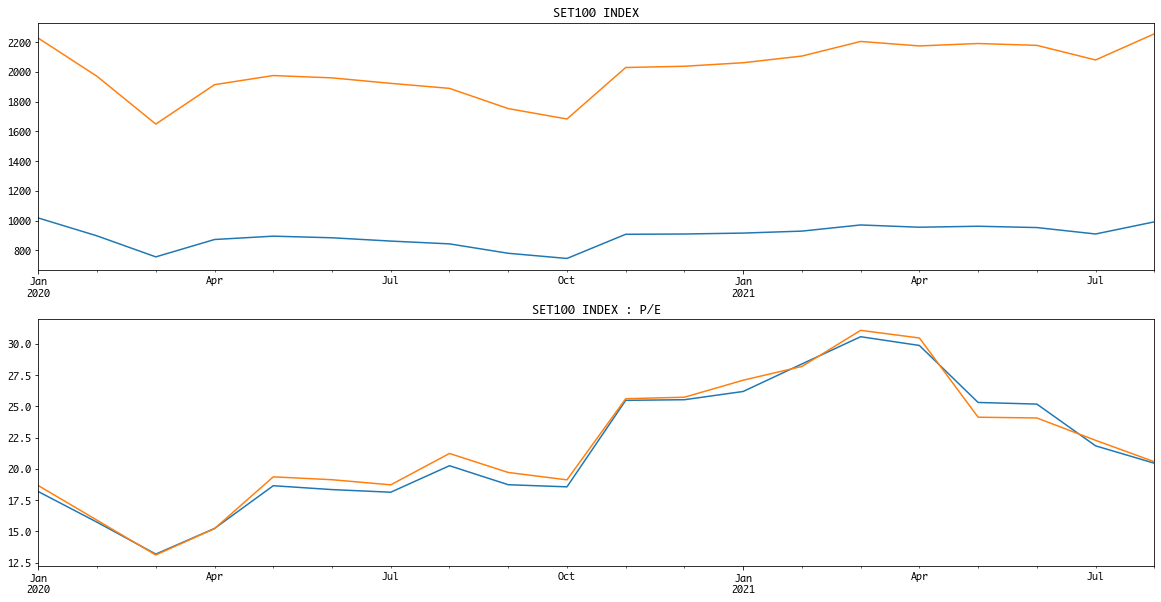

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


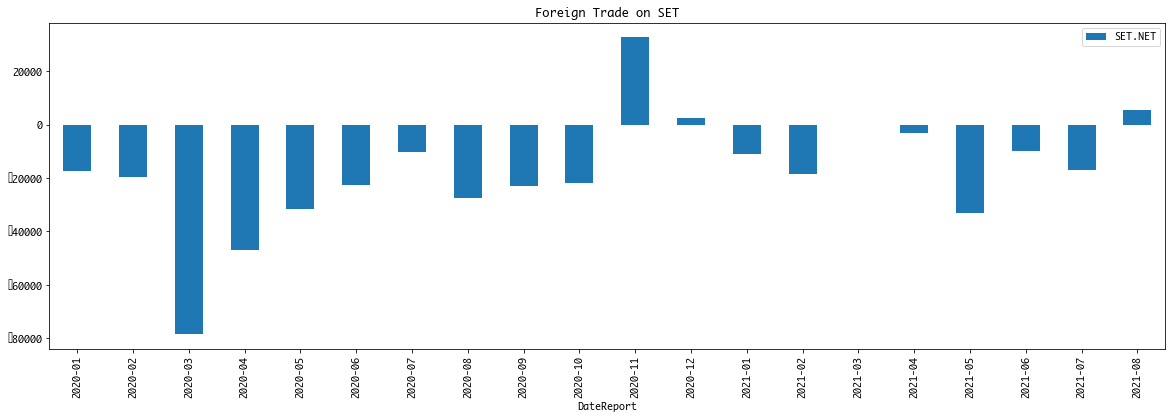

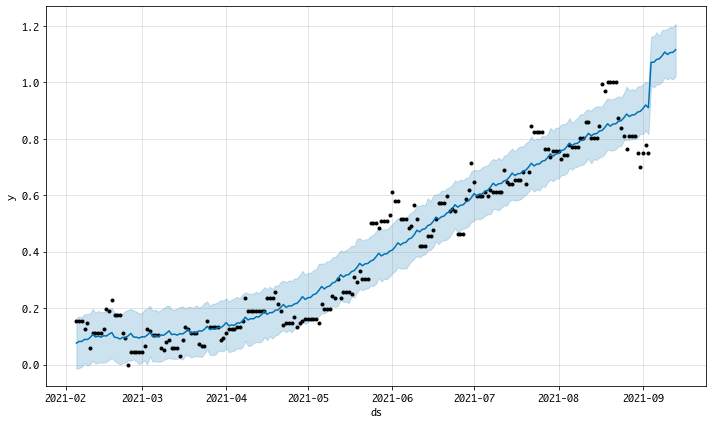

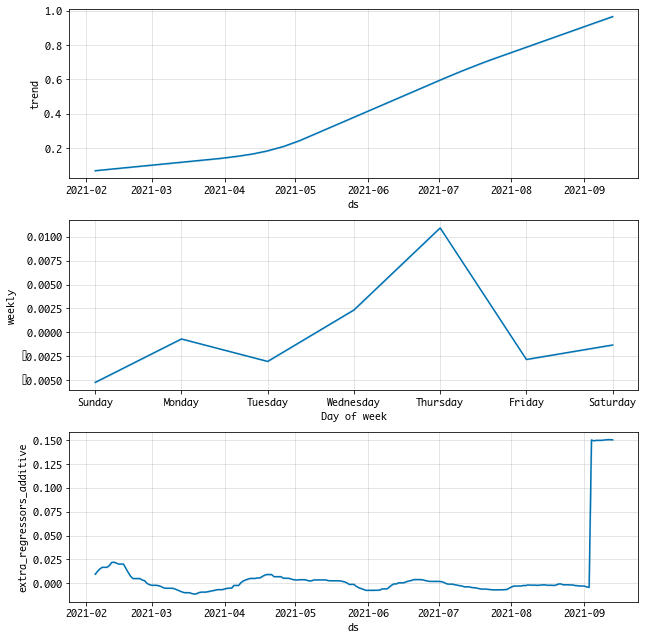

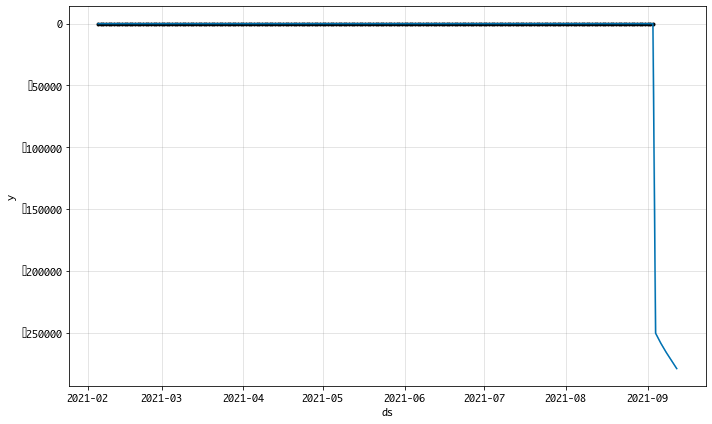

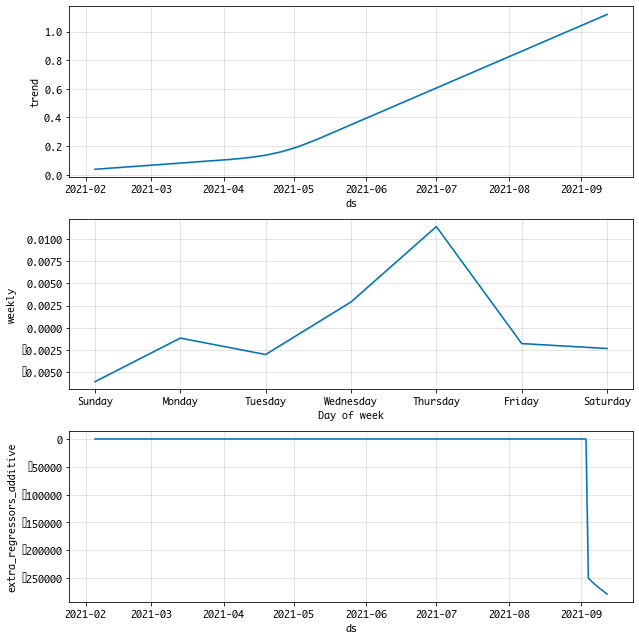

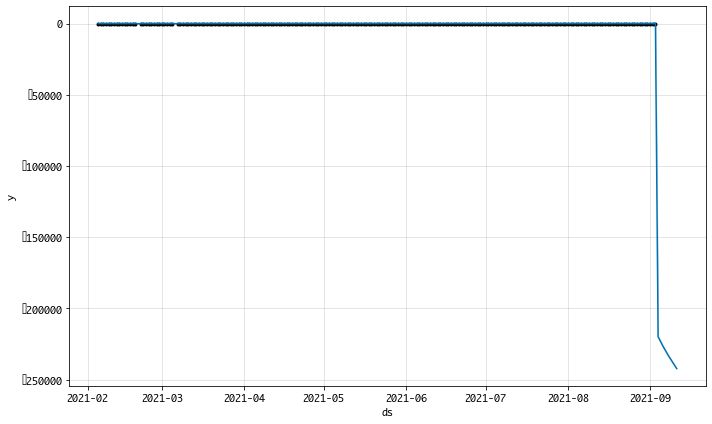

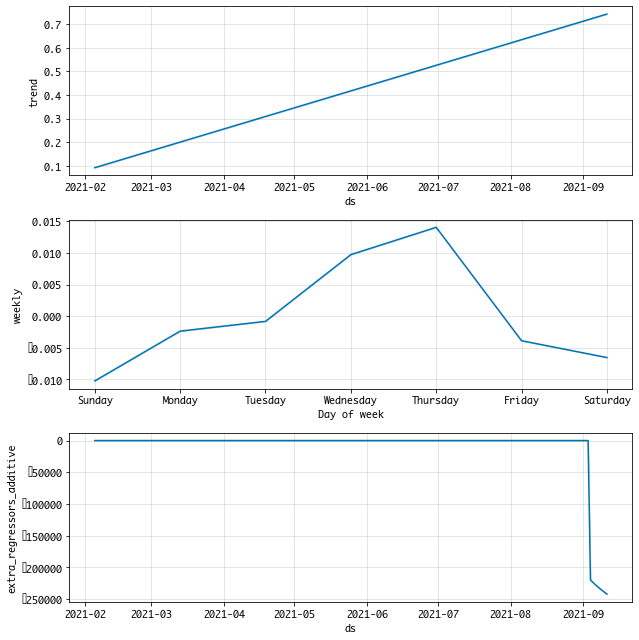

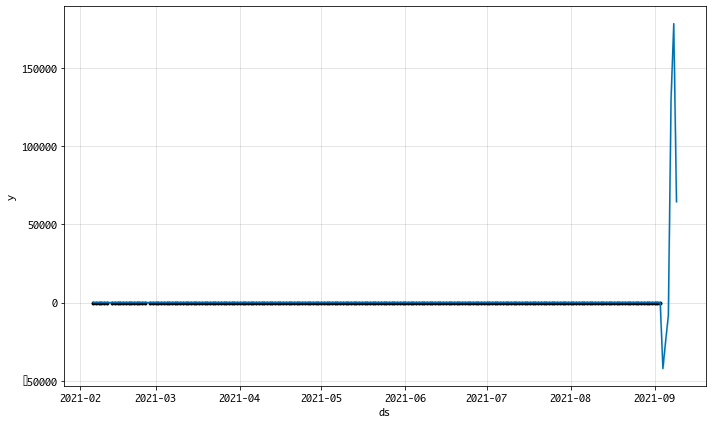

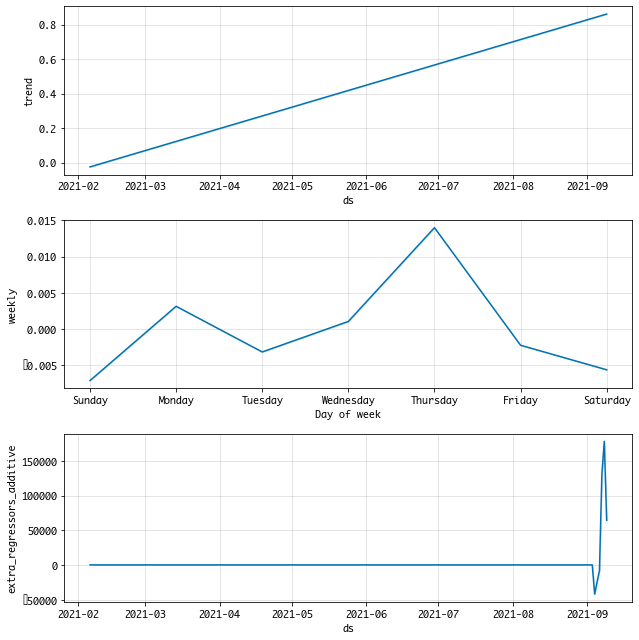

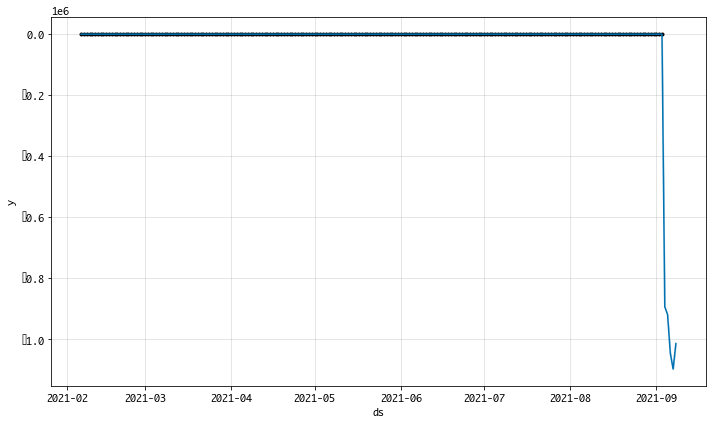

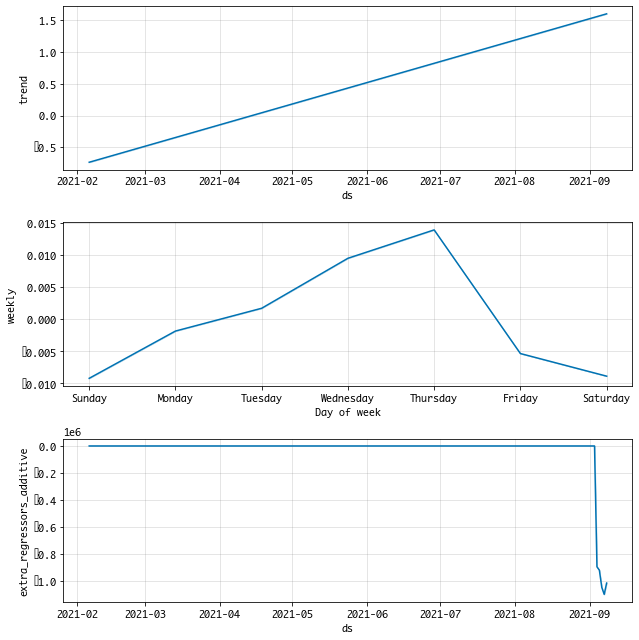

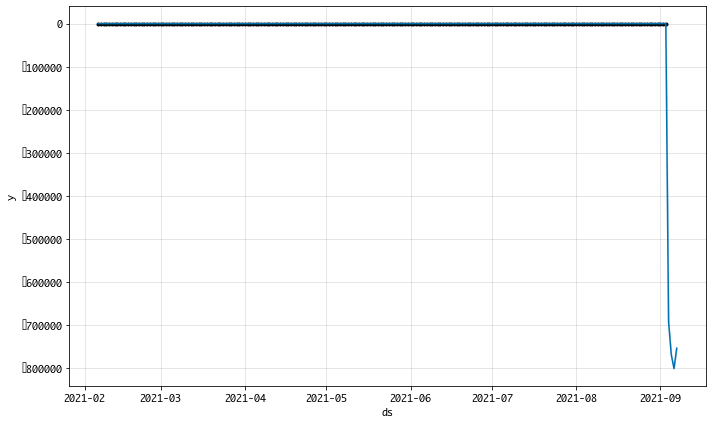

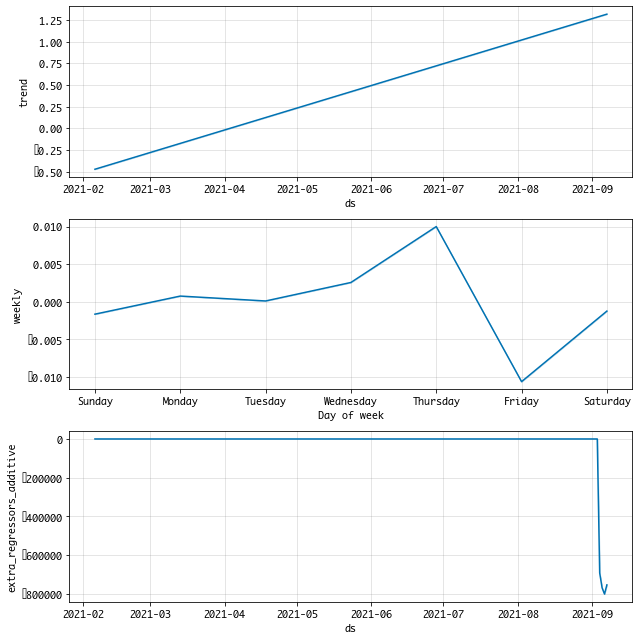

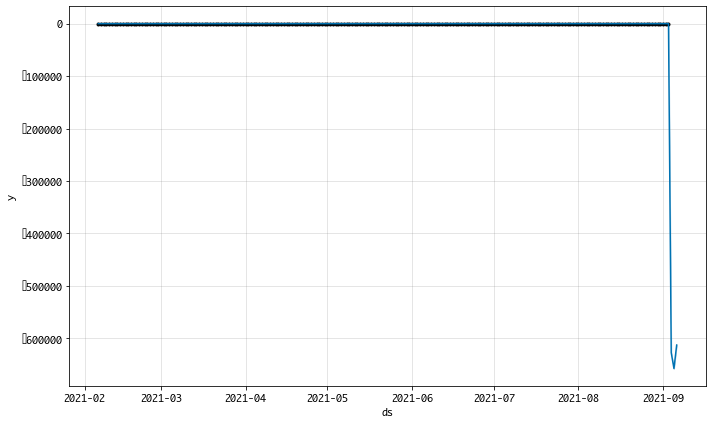

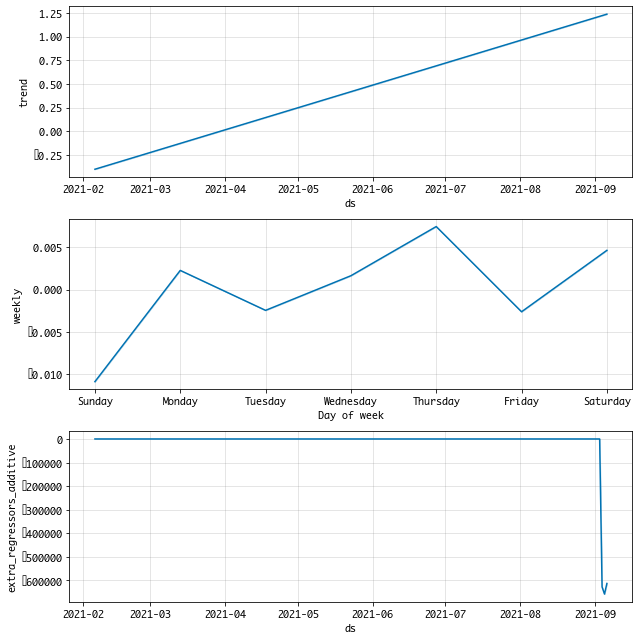

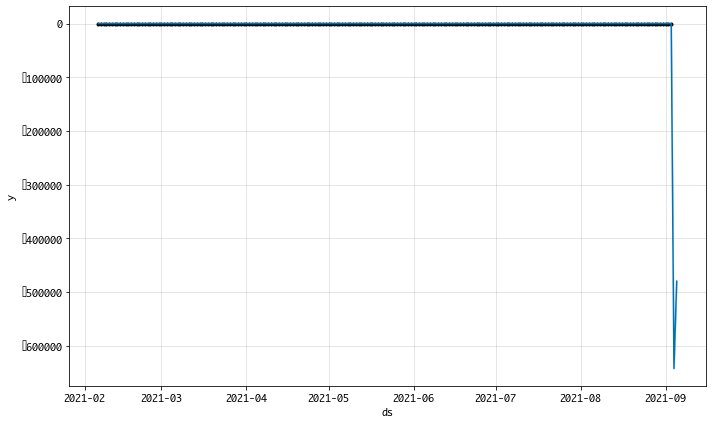

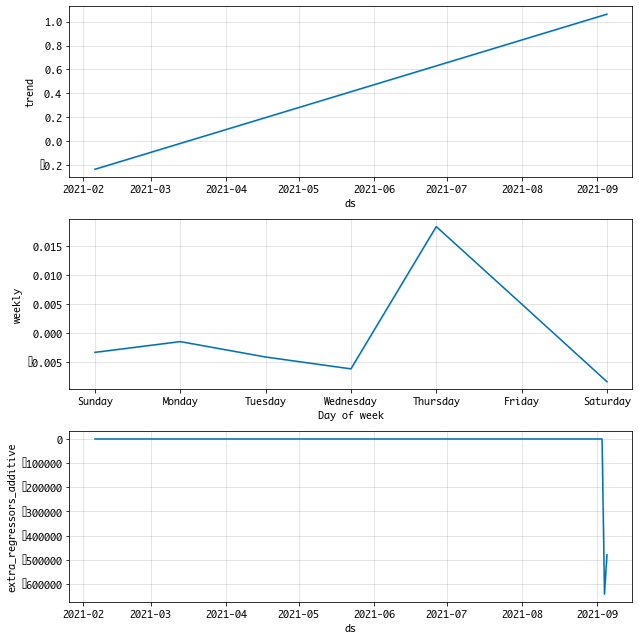

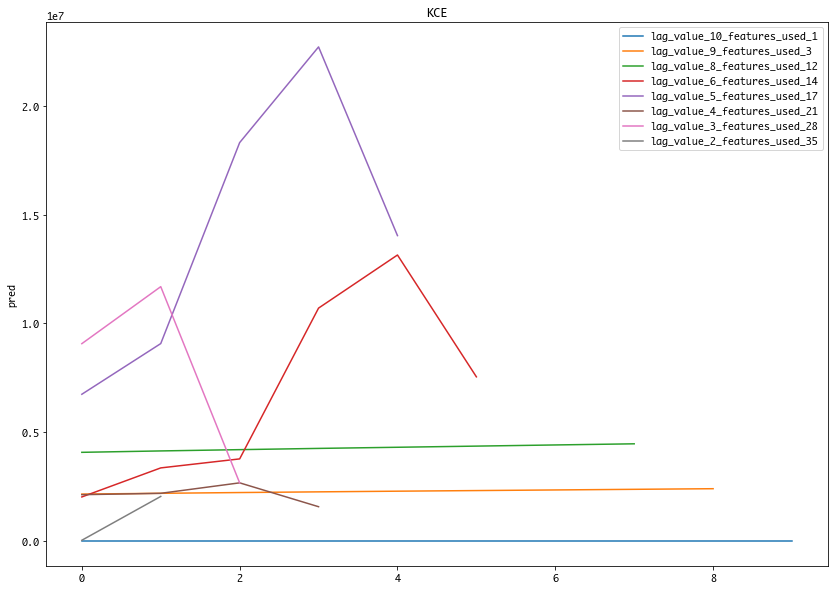

[[10,
          pred
  0  63.288076
  1  63.257971
  2  63.274172
  3  63.274172
  4  63.274172
  5  63.281123
  6  63.290396
  7  63.299677
  8  63.299677
  9  63.292715,
  1],
 [9,
             pred
  0  2.159646e+06
  1  2.195677e+06
  2  2.230324e+06
  3  2.262182e+06
  4  2.292954e+06
  5  2.321209e+06
  6  2.349726e+06
  7  2.378540e+06
  8  2.406770e+06,
  3],
 [8,
             pred
  0  4.078239e+06
  1  4.142459e+06
  2  4.201405e+06
  3  4.258454e+06
  4  4.310730e+06
  5  4.363682e+06
  6  4.417181e+06
  7  4.469547e+06,
  12],
 [6,
             pred
  0  2.028295e+06
  1  3.362446e+06
  2  3.776109e+06
  3  1.070439e+07
  4  1.314396e+07
  5  7.547225e+06,
  14],
 [5,
             pred
  0  6.746068e+06
  1  9.074470e+06
  2  1.830820e+07
  3  2.270495e+07
  4  1.403548e+07,
  17],
 [4,
             pred
  0  2.132334e+06
  1  2.195247e+06
  2  2.676244e+06
  3  1.579815e+06,
  21],
 [3,
             pred
  0  9.070693e+06
  1  1.168956e+07
  2  2.674683e+06,
  28],
 [2,
  

In [71]:
stock_symbol = 'KCE'
stock_all_data = sf.get_all_sources_stock_data(stock_symbol)
pred_list, prophet_model_list = get_predict_results(stock_symbol, stock_all_data)
plot_pred_results(pred_list,stock_symbol)
pred_list

File already exist....


  0%|          | 0/9 [00:00<?, ?it/s]

Fetching stock data in sector: TEAM
Fetching stock data in sector: KCE
Fetching stock data in sector: METCO
Fetching stock data in sector: HANA
Fetching stock data in sector: SVI
Fetching stock data in sector: NEX
Fetching stock data in sector: DELTA
Fetching stock data in sector: CCET
Fetching stock data in sector: SMT


  0%|          | 0/100 [00:00<?, ?it/s]

Fetching stock data set100: AAV
Fetching stock data set100: ACE
Fetching stock data set100: ADVANC
Fetching stock data set100: AEONTS
Fetching stock data set100: AMATA
Fetching stock data set100: AOT
Fetching stock data set100: AP
Fetching stock data set100: BAM
Fetching stock data set100: BANPU
Fetching stock data set100: BBL
Fetching stock data set100: BCH
Fetching stock data set100: BCP
Fetching stock data set100: BCPG
Fetching stock data set100: BDMS
Fetching stock data set100: BEC
Fetching stock data set100: BEM
Fetching stock data set100: BGRIM
Fetching stock data set100: BH
Fetching stock data set100: BJC
Fetching stock data set100: BTS
Fetching stock data set100: CBG
Fetching stock data set100: CENTEL
Fetching stock data set100: CHG
Fetching stock data set100: CK
Fetching stock data set100: CKP
Fetching stock data set100: COM7
Fetching stock data set100: CPALL
Fetching stock data set100: CPF
Fetching stock data set100: CPN
Fetching stock data set100: CRC
Fetching stock data set

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching stock data correlation: KCE
Fetching stock data correlation: BEC
Fetching stock data correlation: SINGER
Fetching stock data correlation: HANA
Fetching stock data correlation: KTC


0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.4238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83        373.84    0.00462938       202.372   2.518e-05       0.001      138  LS failed, Hessian reset 
      99       375.141   0.000557818       64.3346       0.217           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       375.431    0.00138161       98.5041   1.592e-05       0.001      222  LS failed, Hessian reset 
     199       375.544   1.06467e-06       84.8247           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       381.838    0.00182935       88.6417           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       382.065   0.000200593        74.214   2.825e-06       0.001      541  LS failed, Hessian rese

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2367
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2231
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2089
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1941
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1786
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1627
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1460
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1139
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0986


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: DELTA_CLOSE
data_index: 0
features_used: (200, 1)
lag value in train_test 10
[0.58826859 0.58826859 0.58826859 0.58826859 0.58826859 0.58826859
 0.58826859 0.58826859 0.58826859 0.58826859]
           pred
0  11861.372021
1  11834.324790
2  11820.089642
3  11820.089642
4  11820.089642
5  11817.242388
6  11768.841311
7  11818.665453
8  11932.556754
9  12050.727368
Initial log joint probability = -11.4238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       448.437    0.00022939       59.9171       0.697       0.697      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       449.382   3.26712e-05       60.6026   4.354e-07       0.001      298  LS failed, Hessian reset 
     199       449.385   5.93822e-05       81.1683           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       449.755   

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 3ms/step - loss: 0.2404
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2289
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2163
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2028
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1893
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1722
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1560
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1367
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1148
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0921


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: DELTA_CLOSE
data_index: 1
features_used: (200, 3)
lag value in train_test 9
[0.57852014 0.57852014 0.57852014 0.57852014 0.57852014 0.57852014
 0.57852014 0.57852014 0.57852014]
           pred
0  37376.683459
1  37387.613858
2  37387.613858
3  37387.613858
4  37424.307807
5  37551.502408
6  38167.898709
7  39218.305163
8  40264.188382
Initial log joint probability = -11.3758
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87        457.14    0.00172206       176.392   1.167e-05       0.001      151  LS failed, Hessian reset 
      99        458.81    0.00066439       62.6211      0.5319      0.5319      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       460.741    0.00198766       196.229   2.052e-05       0.001      279  LS failed, Hessian reset 
     199       461.357   2.30905e-05       59.2734           1           1      342   
    Iter      log prob        ||dx

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2301
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2168
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2007
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1840
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1656
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1213
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0994
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0790
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0527


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: DELTA_CLOSE
data_index: 2
features_used: (200, 5)
lag value in train_test 8
[0.71023734 0.71023734 0.71023734 0.71023734 0.71023734 0.71023734
 0.71023734 0.71023734]
           pred
0  59514.517603
1  59514.517603
2  59514.517603
3  55150.028386
4  54708.410568
5  55294.830327
6  56426.007532
7  57282.216171
Initial log joint probability = -11.0344
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        442.42   0.000885006       82.1799      0.5655      0.5655      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        444.34   6.77901e-05       84.7974      0.3784           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       444.596   0.000416977       108.368   5.077e-06       0.001      325  LS failed, Hessian reset 
     276       444.644   7.91399e-06       83.3177   8.445e-08       0.001      

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2379
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2229
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2081
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1937
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1780
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1604
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1398
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1181
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0968
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0688


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: DELTA_CLOSE
data_index: 3
features_used: (200, 6)
lag value in train_test 7
[0.67979966 0.67979966 0.67979966 0.67979966 0.67979966 0.67979966
 0.67979966]
            pred
0  118818.514474
1  118818.514474
2  118294.322905
3  118310.464466
4  119707.811064
5  122035.657947
6  123699.299834
Initial log joint probability = -11.311
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       457.772     0.0027885       104.132           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       460.153   1.27644e-06       87.2972       0.434           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       460.153   1.20522e-08       62.7713     0.06068           1      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2449
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2306
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2181
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2053
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1901
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1734
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1557
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1353
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1109
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0847


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: DELTA_CLOSE
data_index: 4
features_used: (200, 7)
lag value in train_test 6
[0.84303505 0.84303505 0.84303505 0.84303505 0.84303505 0.84303505]
           pred
0  1.200745e+07
1  2.129405e+07
2  2.989526e+07
3  9.890312e+07
4  1.231395e+08
5  6.721901e+07
Initial log joint probability = -11.3389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       468.419    0.00961293       80.2574           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       472.148   0.000412903       81.6414      0.5866      0.5866      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       472.281   1.73066e-05       88.8369      0.3582           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334        472.55   0.000655694       114.167   6.562e-06     

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2410
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2314
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2221
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2127
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2023
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1922
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1788
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1626
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1464
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1261


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: DELTA_CLOSE
data_index: 5
features_used: (200, 8)
lag value in train_test 5
[0.88542177 0.88542177 0.88542177 0.88542177 0.88542177]
           pred
0  5.669704e+07
1  5.754224e+07
2  1.364270e+08
3  1.831011e+08
4  1.800602e+08
Initial log joint probability = -11.3389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       490.663   0.000723935       99.5054           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       498.567   0.000414658       100.339      0.8869      0.8869      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       498.712   0.000298294       89.9427   2.397e-06       0.001      290  LS failed, Hessian reset 
     270        498.77   2.45716e-08       102.309           1           1      357   
Optimization terminated normally: 
  Convergence detected: relative gradien

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2413
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2300
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2185
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2050
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1894
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1732
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1518
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1266
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0935
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0601
stock: DELTA_CLOSE
data_index: 6
features_used: (200, 14)
lag value in train_test 4
[0.84656451 0.84656451 0.84656451 0.84656451]
           pred
0  7.782196e+07
1  1.442809e+08
2  3.486889e+08
3  3.496448e+08


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.3389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       523.615    0.00209079       103.464       2.036      0.2036      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       532.688    0.00864752        177.78           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       535.998    0.00819815       132.742           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       538.628   0.000278773       116.296      0.5314      0.5314      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       541.436    0.00645154       118.749           1           1      538   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2334
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2086
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1784
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1384
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0960
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0511
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0316
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0311
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0251
stock: DELTA_CLOSE
data_index: 7
features_used: (200, 28)
lag value in train_test 3
[0.88008495 0.88008495 0.88008495]
           pred
0  1.626135e+08
1  2.515387e+08
2  4.774445e+08


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.3389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       540.884    0.00953432       377.532           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       550.559    0.00429144       176.405      0.9037      0.9037      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       557.402   0.000560632       166.534      0.3976           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       561.554   0.000592639       121.775      0.5818      0.5818      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       564.873   0.000572478       196.781      0.7576      0.7576      557   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2455
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2266
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2058
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1807
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1460
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0963
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0484
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0339
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0261
stock: DELTA_CLOSE
data_index: 8
features_used: (200, 36)
lag value in train_test 2
[0.85161976 0.85161976]
           pred
0  8.274150e+07
1  2.246106e+08


/var/folders/9x/vhwmst995hn3jwhjkyh5vvlw0000gp/T/ipykernel_37789/852116697.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(14,10))


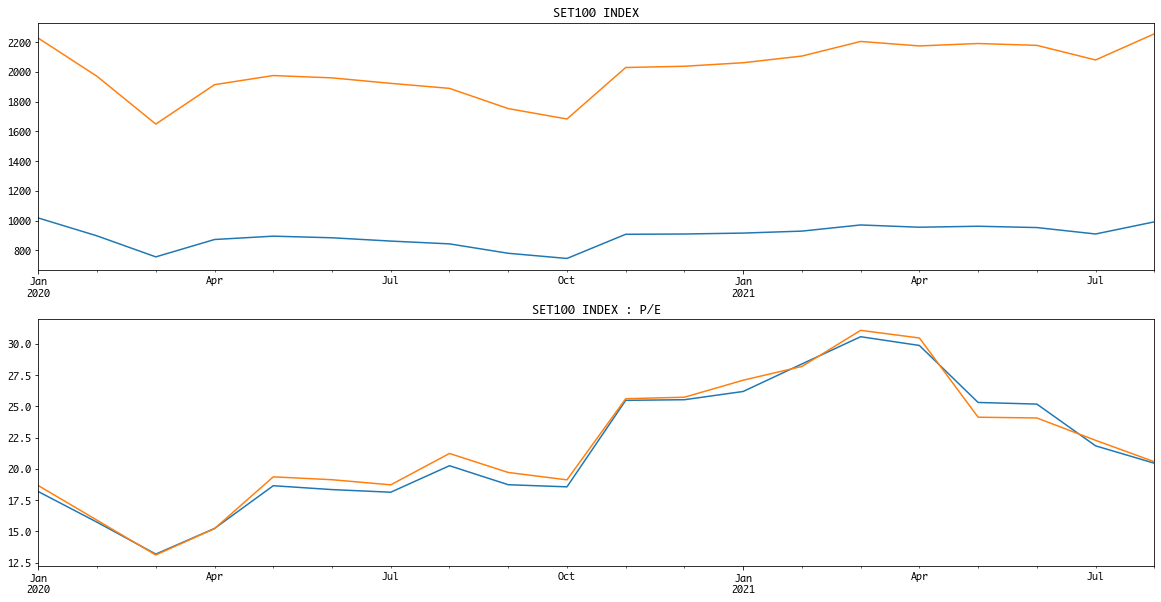

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


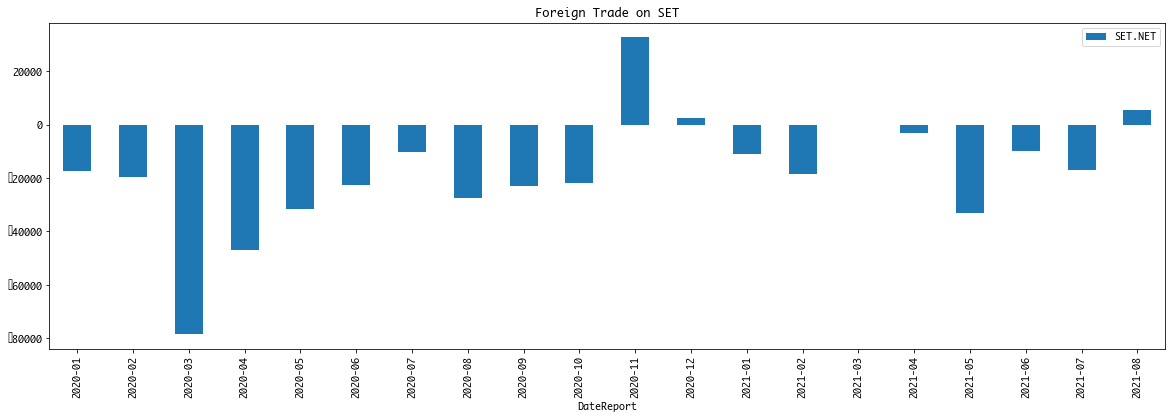

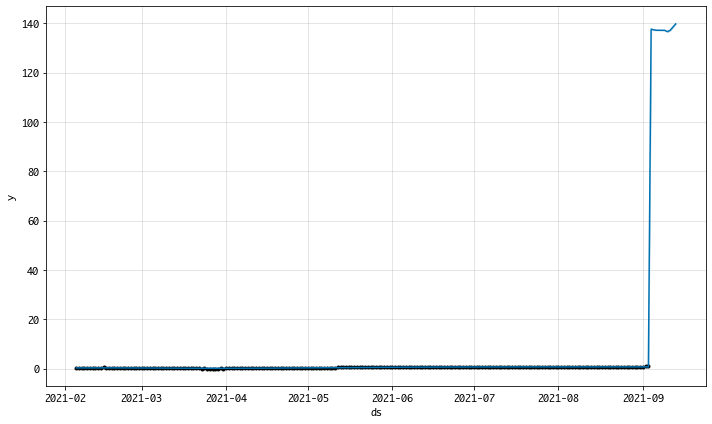

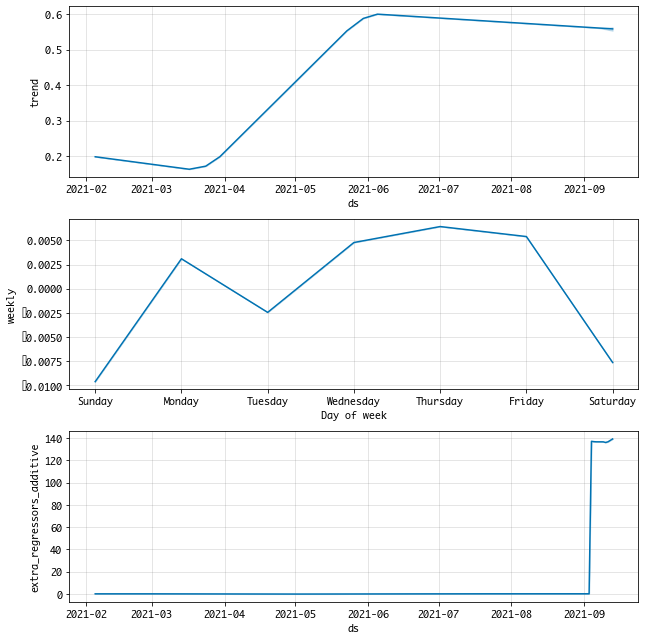

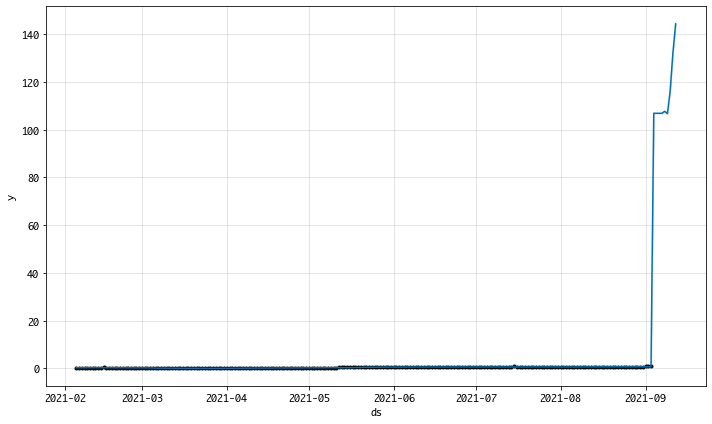

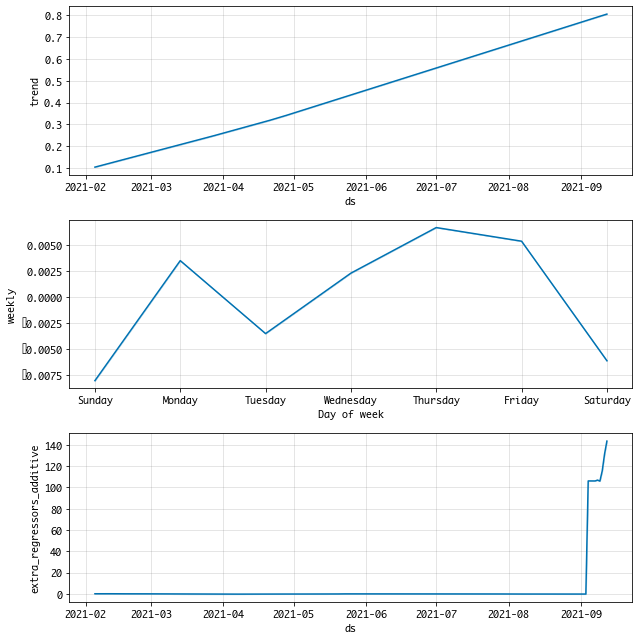

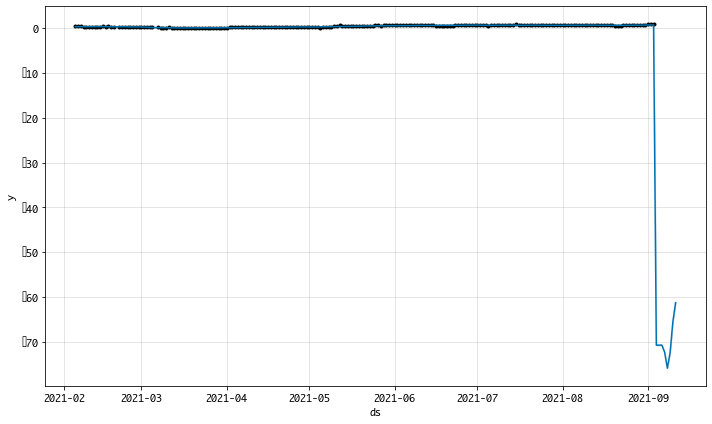

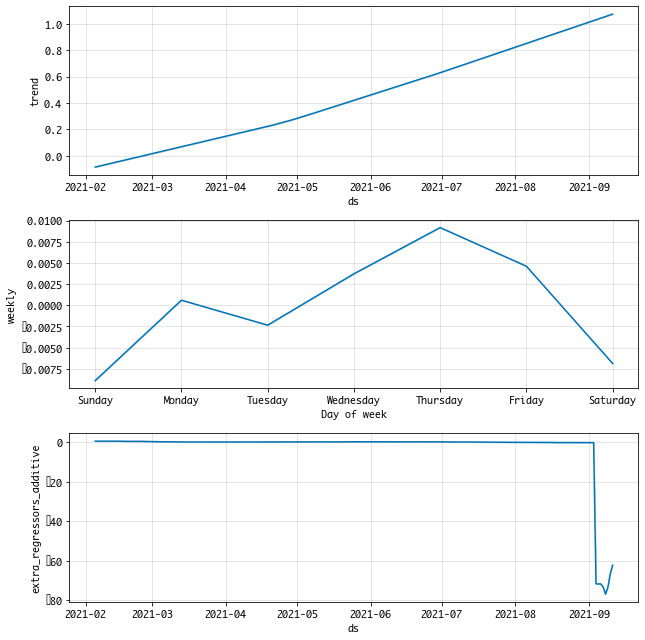

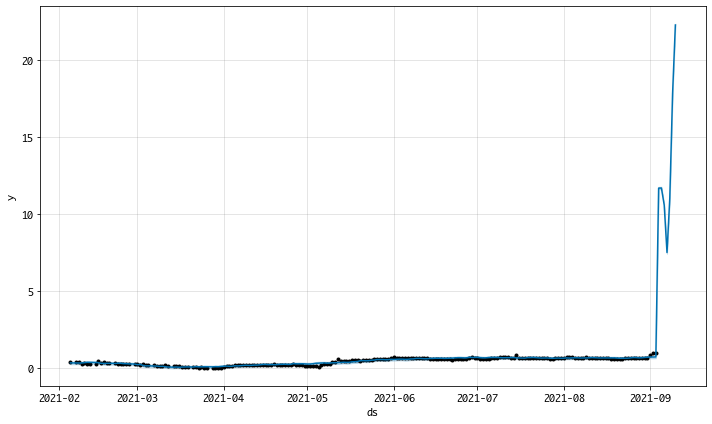

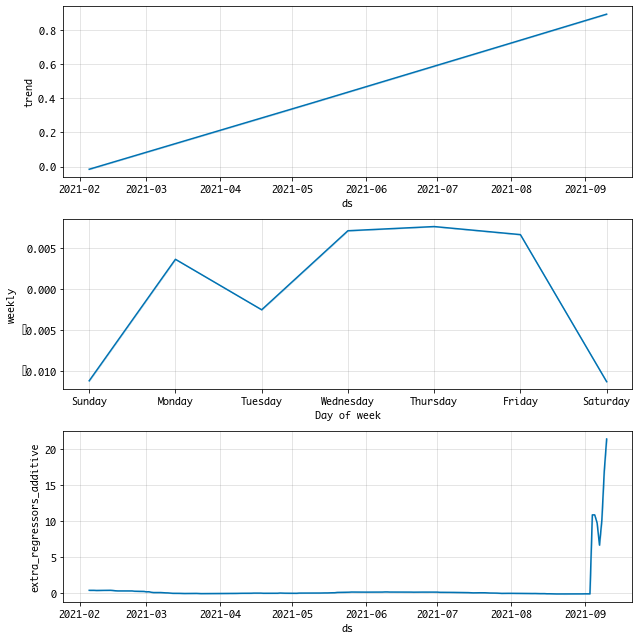

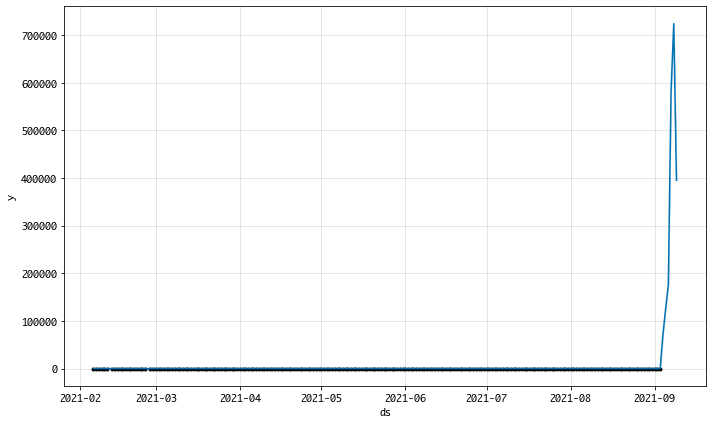

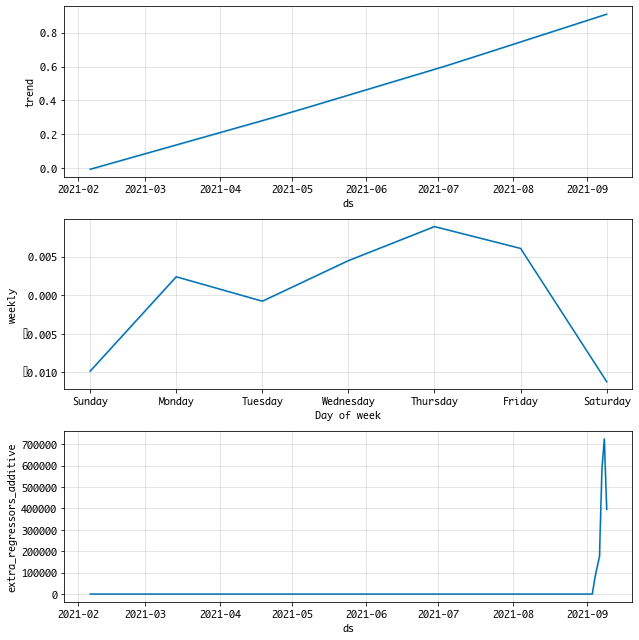

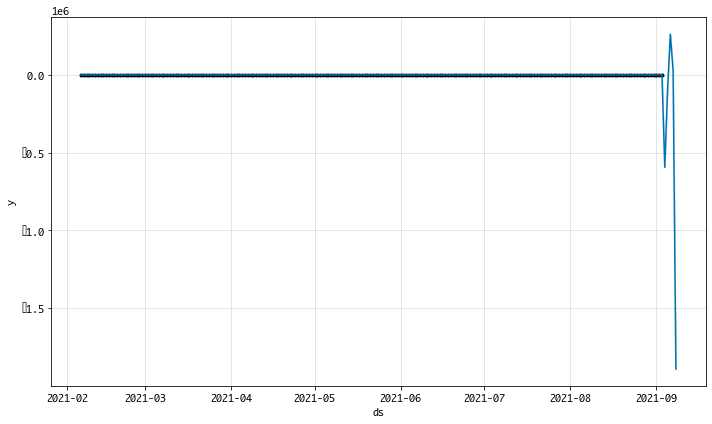

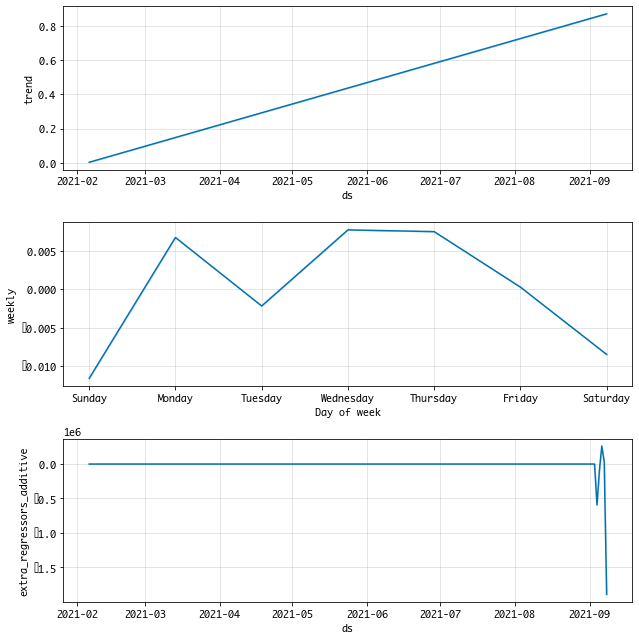

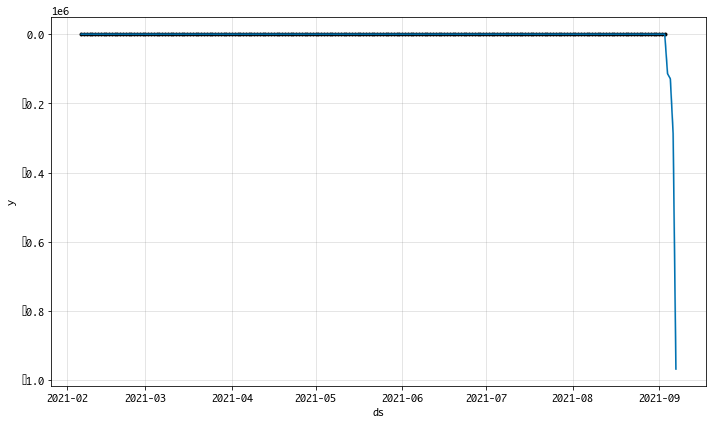

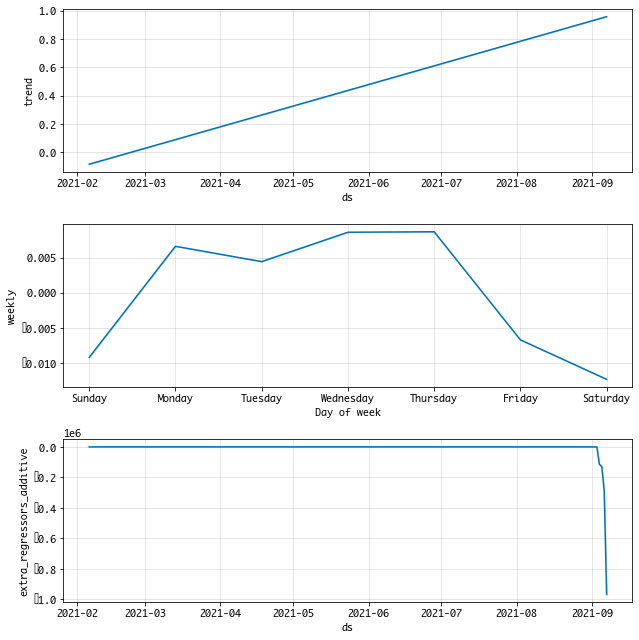

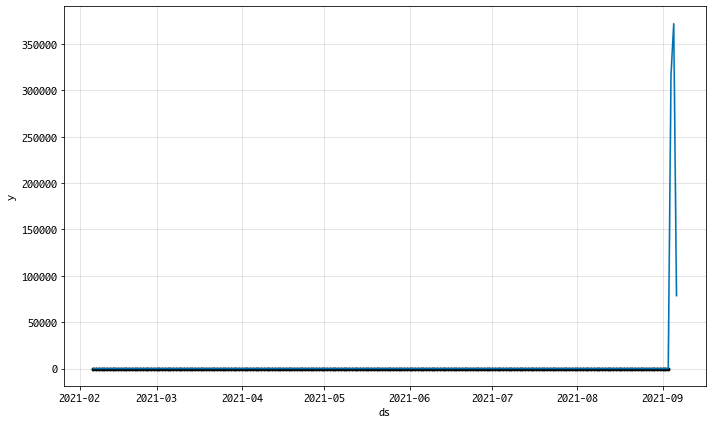

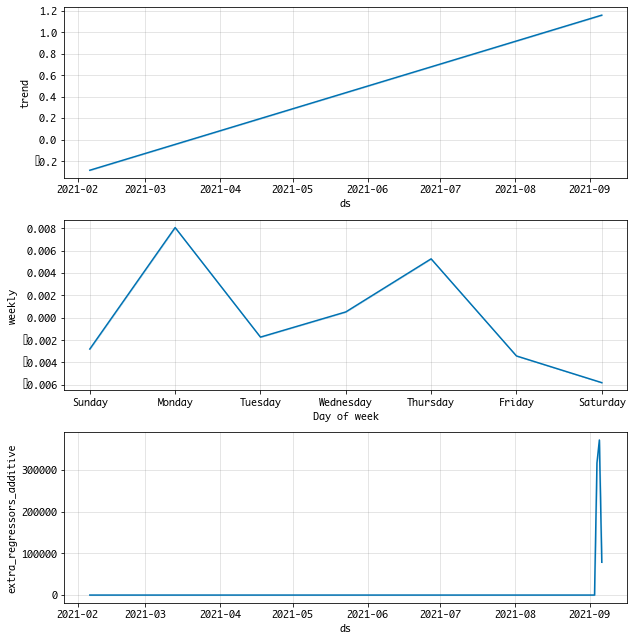

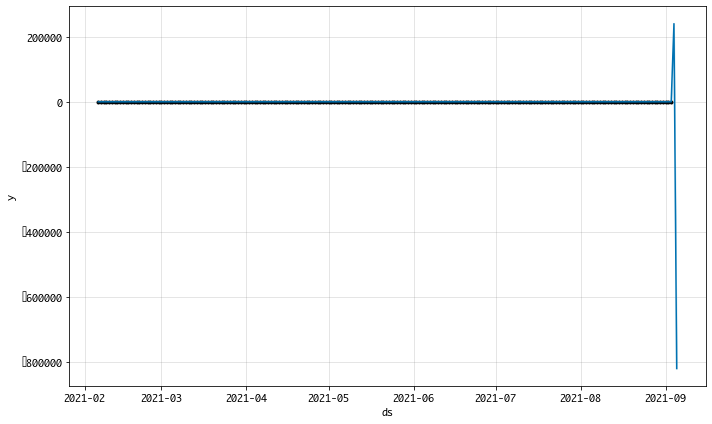

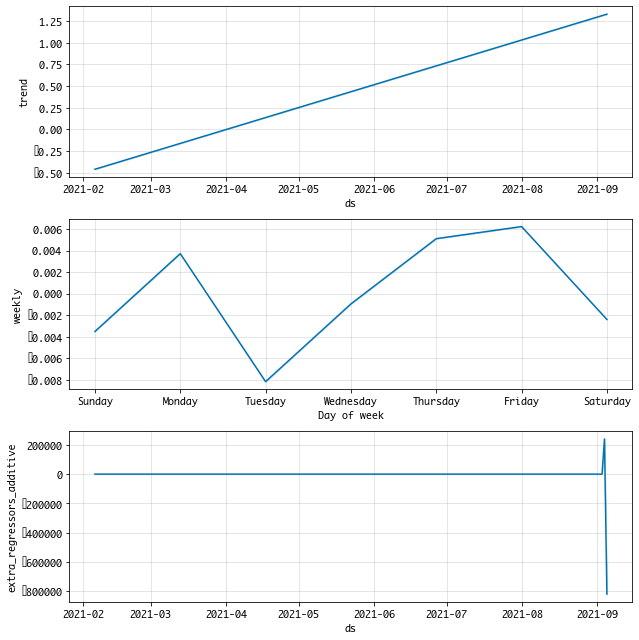

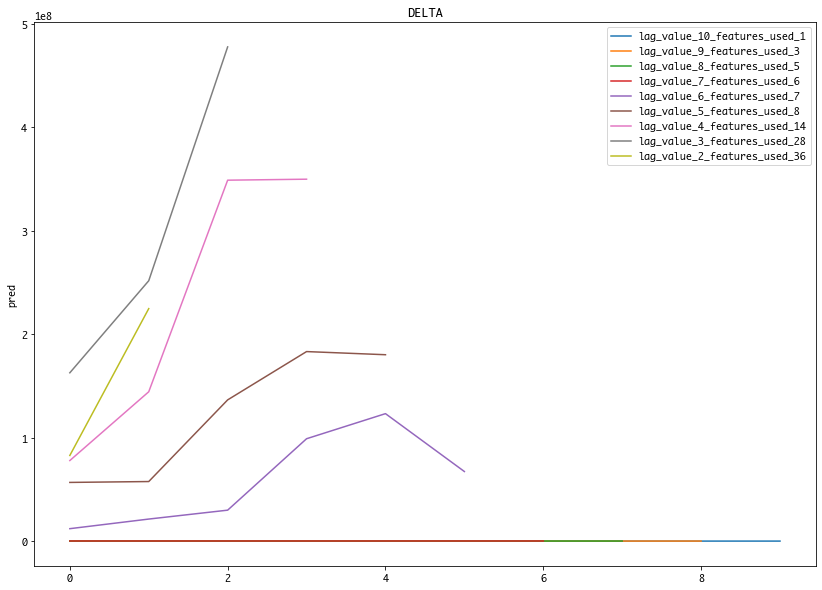

[[10,
             pred
  0  11861.372021
  1  11834.324790
  2  11820.089642
  3  11820.089642
  4  11820.089642
  5  11817.242388
  6  11768.841311
  7  11818.665453
  8  11932.556754
  9  12050.727368,
  1],
 [9,
             pred
  0  37376.683459
  1  37387.613858
  2  37387.613858
  3  37387.613858
  4  37424.307807
  5  37551.502408
  6  38167.898709
  7  39218.305163
  8  40264.188382,
  3],
 [8,
             pred
  0  59514.517603
  1  59514.517603
  2  59514.517603
  3  55150.028386
  4  54708.410568
  5  55294.830327
  6  56426.007532
  7  57282.216171,
  5],
 [7,
              pred
  0  118818.514474
  1  118818.514474
  2  118294.322905
  3  118310.464466
  4  119707.811064
  5  122035.657947
  6  123699.299834,
  6],
 [6,
             pred
  0  1.200745e+07
  1  2.129405e+07
  2  2.989526e+07
  3  9.890312e+07
  4  1.231395e+08
  5  6.721901e+07,
  7],
 [5,
             pred
  0  5.669704e+07
  1  5.754224e+07
  2  1.364270e+08
  3  1.831011e+08
  4  1.800602e+08,
  8],
 

In [76]:
stock_symbol = 'DELTA'
stock_all_data = sf.get_all_sources_stock_data(stock_symbol)
pred_list, prophet_model_list = get_predict_results(stock_symbol, stock_all_data)
plot_pred_results(pred_list,stock_symbol)
pred_list

File already exist....


  0%|          | 0/11 [00:00<?, ?it/s]

Fetching stock data in sector: CIMBT
Fetching stock data in sector: TISCO
Fetching stock data in sector: KKP
Fetching stock data in sector: KBANK
Fetching stock data in sector: BBL
Fetching stock data in sector: SCB
Fetching stock data in sector: BAY
Fetching stock data in sector: TTB
Fetching stock data in sector: TCAP
Fetching stock data in sector: KTB
Fetching stock data in sector: LHFG


  0%|          | 0/100 [00:00<?, ?it/s]

Fetching stock data set100: AAV
Fetching stock data set100: ACE
Fetching stock data set100: ADVANC
Fetching stock data set100: AEONTS
Fetching stock data set100: AMATA
Fetching stock data set100: AOT
Fetching stock data set100: AP
Fetching stock data set100: BAM
Fetching stock data set100: BANPU
Fetching stock data set100: BBL
Fetching stock data set100: BCH
Fetching stock data set100: BCP
Fetching stock data set100: BCPG
Fetching stock data set100: BDMS
Fetching stock data set100: BEC
Fetching stock data set100: BEM
Fetching stock data set100: BGRIM
Fetching stock data set100: BH
Fetching stock data set100: BJC
Fetching stock data set100: BTS
Fetching stock data set100: CBG
Fetching stock data set100: CENTEL
Fetching stock data set100: CHG
Fetching stock data set100: CK
Fetching stock data set100: CKP
Fetching stock data set100: COM7
Fetching stock data set100: CPALL
Fetching stock data set100: CPF
Fetching stock data set100: CPN
Fetching stock data set100: CRC
Fetching stock data set

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching stock data correlation: MINT
Fetching stock data correlation: KBANK
Fetching stock data correlation: BCP
Fetching stock data correlation: AMATA
Fetching stock data correlation: KKP


0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -12.9817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       248.975    0.00192852       71.2301   2.612e-05       0.001      146  LS failed, Hessian reset 
      99       249.115   0.000708734       93.2974           1           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       249.688     0.0022445       77.2596   3.211e-05       0.001      240  LS failed, Hessian reset 
     199       250.001   0.000568753       83.2238           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       250.522    0.00339435       68.7062   4.549e-05       0.001      457  LS failed, Hessian reset 
     299       250.916   0.000240957       78.3744           1           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.3173
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3023
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2871
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2714
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2553
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2384
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2217
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2028
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1853
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1669


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: SCB_CLOSE
data_index: 0
features_used: (200, 1)
lag value in train_test 10
[0.60154513 0.60154513 0.60154513 0.60154513 0.60154513 0.60154513
 0.60154513 0.60154513 0.60154513 0.60154513]
       pred
0  222.4087
1  222.4087
2  222.4087
3  222.4087
4  222.4087
5  222.4087
6  222.4087
7  222.4087
8  222.4087
9  222.4087
Initial log joint probability = -12.9817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       260.853    0.00218426       80.0942   2.765e-05       0.001      131  LS failed, Hessian reset 
      99       260.951   8.65533e-05         73.06        0.18      0.8881      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       260.956   2.27599e-08       70.7972      0.3159      0.6607      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.3293
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3136
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2991
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2846
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2694
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2542
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2383
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2206
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2044
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1857


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: SCB_CLOSE
data_index: 1
features_used: (200, 2)
lag value in train_test 9
[0.51637803 0.51637803 0.51637803 0.51637803 0.51637803 0.51637803
 0.51637803 0.51637803 0.51637803]
         pred
0  268.640994
1  269.093787
2  269.093787
3  269.093787
4  268.640994
5  269.093787
6  267.280665
7  268.641008
8  266.826530
Initial log joint probability = -12.9517
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       267.692   3.61926e-05        73.611      0.2752      0.6853      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       267.798   7.25865e-07       88.3685      0.3838      0.3838      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       267.939   0.000270731       70.0934   3.983e-06       0.001      385  LS failed, Hessian reset 
     299       267.963   0.000371614       88.3337       5.738      0.5738 

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.3201
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3069
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2926
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2771
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2604
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2424
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2236
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2012
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1795
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1559


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: SCB_CLOSE
data_index: 2
features_used: (200, 3)
lag value in train_test 6
[0.59041174 0.59041174 0.59041174 0.59041174 0.59041174 0.59041174]
         pred
0  704.992139
1  707.101228
2  704.992139
3  702.732543
4  700.829496
5  701.029397
Initial log joint probability = -13.0025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.057   0.000625844       78.2803           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        367.73   3.54672e-06       84.7456      0.9544      0.9544      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       367.731   4.46437e-07       90.1638   5.585e-09       0.001      310  LS failed, Hessian reset 
     240       367.731   9.99079e-09        67.761      0.4102      0.4102      329   
Optimization terminated normally: 
  Convergence detected: absol

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.3171
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3000
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2838
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2676
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2493
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2296
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2066
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1776
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1523
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1157


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: SCB_CLOSE
data_index: 3
features_used: (200, 6)
lag value in train_test 5
[0.81516379 0.81516379 0.81516379 0.81516379 0.81516379]
          pred
0  1542.683642
1  1372.637423
2   896.293528
3  1414.461767
4  1081.617560
Initial log joint probability = -13.0025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       392.633    0.00248902       98.4856    2.61e-05       0.001      143  LS failed, Hessian reset 
      99        392.77   0.000139453       73.5825           1           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       393.099   0.000597646       69.6985      0.8511      0.8511      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       393.187   3.68565e-05       93.6725      0.3904      0.3904      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.3237
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3099
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2839
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2702
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2540
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2371
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2158
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1928
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1656


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: SCB_CLOSE
data_index: 4
features_used: (200, 7)
lag value in train_test 4
[0.71032747 0.71032747 0.71032747 0.71032747]
         pred
0  644.251462
1  485.354430
2  752.625720
3  486.475184
Initial log joint probability = -13.0025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.205    0.00158587       89.8557      0.5092      0.5092      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       414.862   0.000159633       91.2016      0.2294      0.2294      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262        415.31   0.000647093       72.7274   7.721e-06       0.001      354  LS failed, Hessian reset 
     299       415.479   0.000144747       105.705           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       415.492

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.3160
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2973
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2772
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2533
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2271
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1965
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1603
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1271
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0833
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0521


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: SCB_CLOSE
data_index: 5
features_used: (200, 8)
lag value in train_test 3
[0.70323088 0.70323088 0.70323088]
          pred
0  1291.133022
1  1391.078945
2  1313.177841
Initial log joint probability = -13.0025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.128    0.00161959       159.007      0.8219      0.8219      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       475.328   2.03773e-06       99.0205         0.5         0.5      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       475.602   9.48751e-05        101.68           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       475.607   9.86932e-06       102.414   9.661e-08       0.001      406  LS failed, Hessian reset 
     352       475.609   2.13694e-08       

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.3256
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3030
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2806
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2531
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2215
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1778
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1374
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0849
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0482
stock: SCB_CLOSE
data_index: 6
features_used: (200, 20)
lag value in train_test 2
[0.87512958 0.87512958]
          pred
0  1826.803677
1  1775.080940


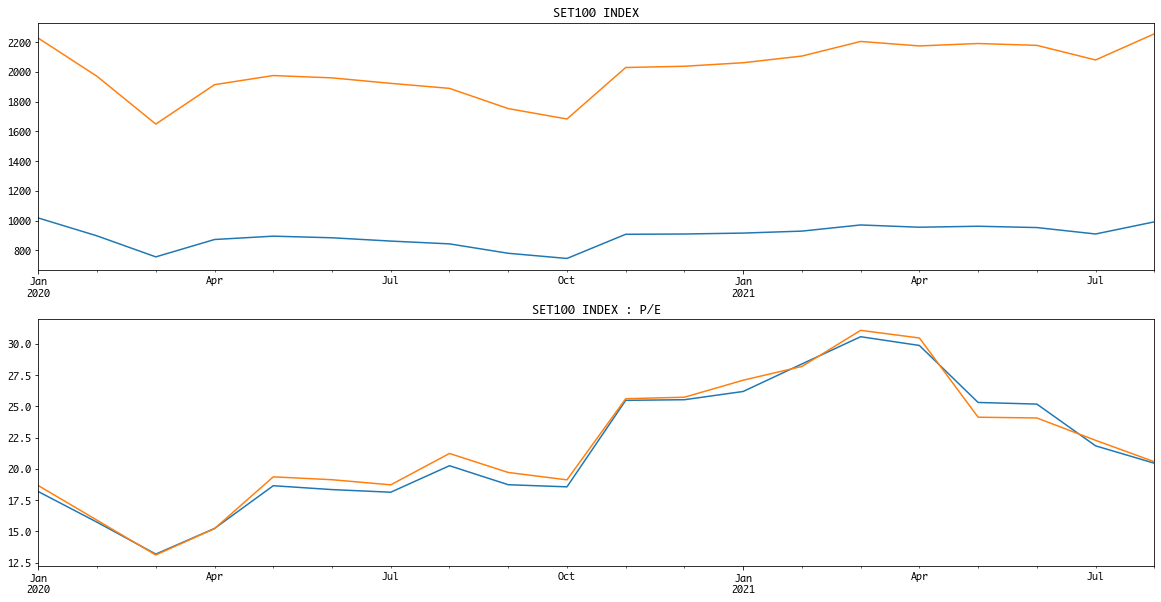

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


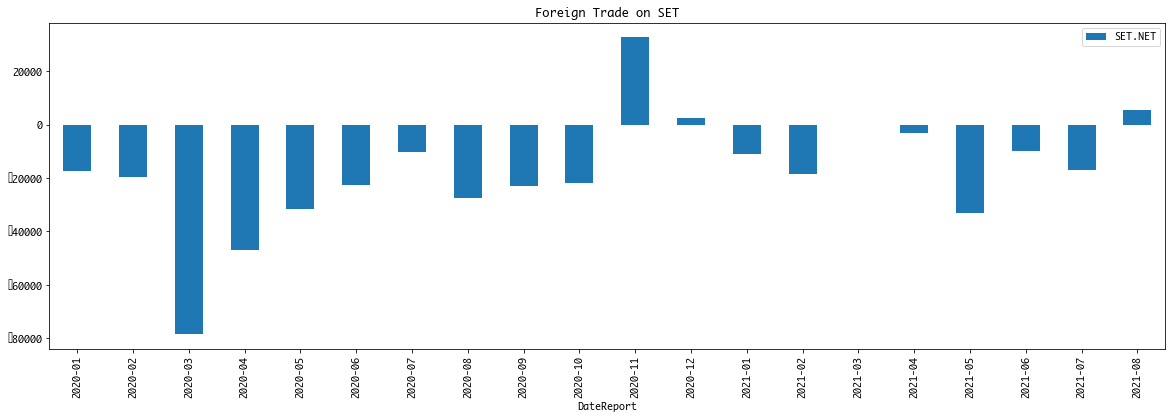

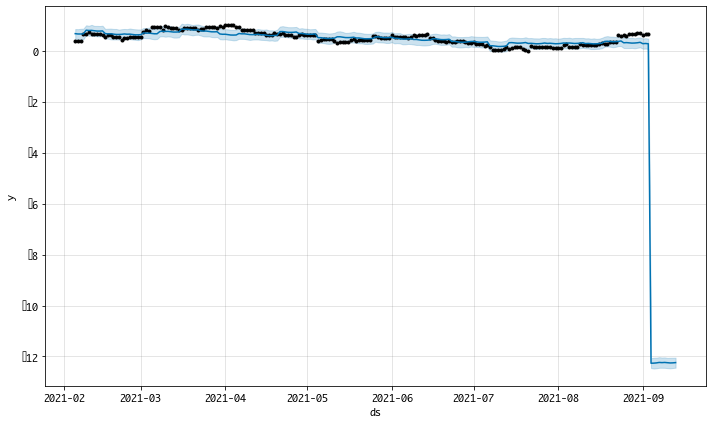

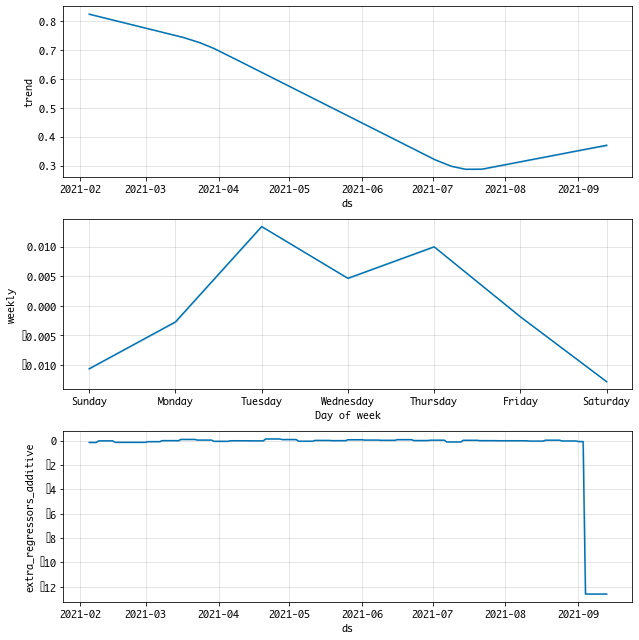

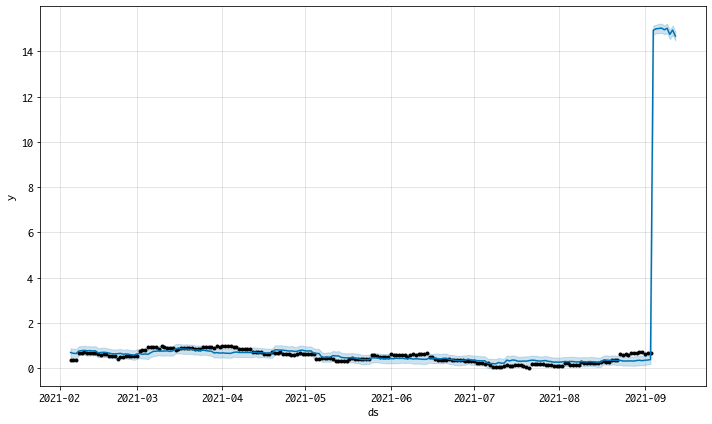

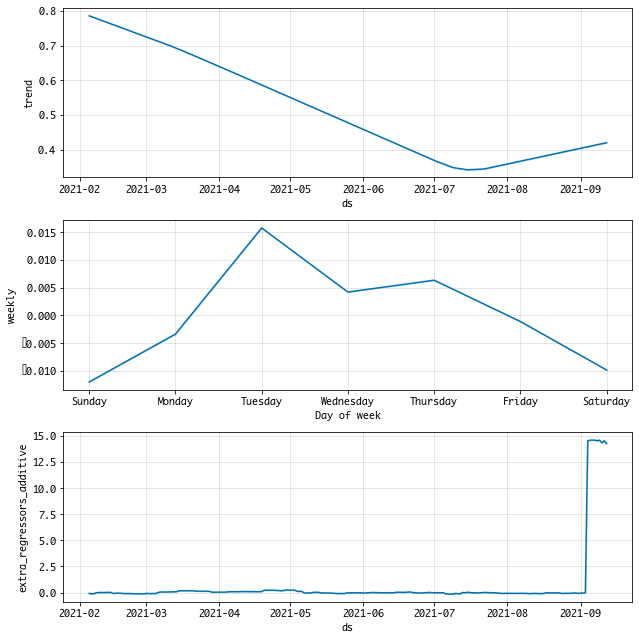

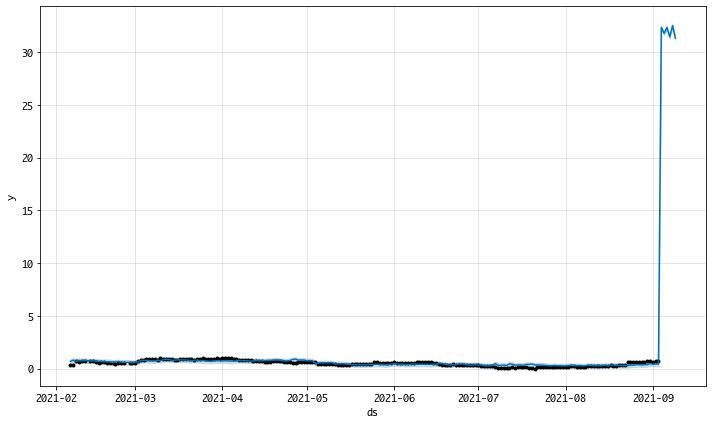

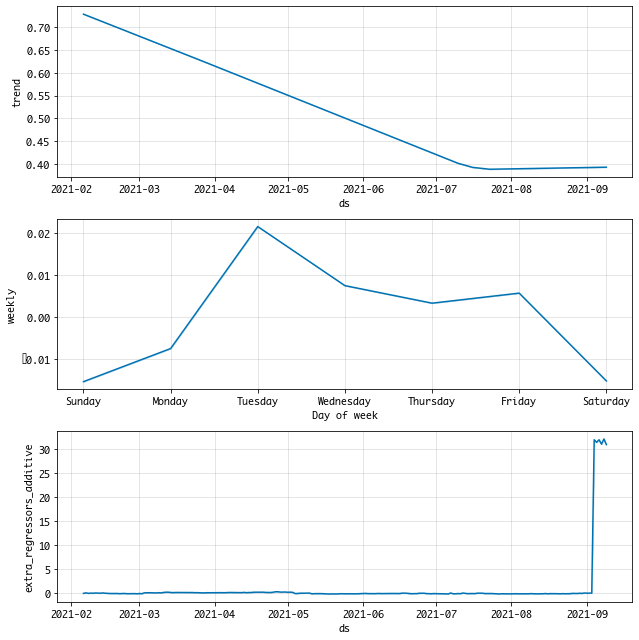

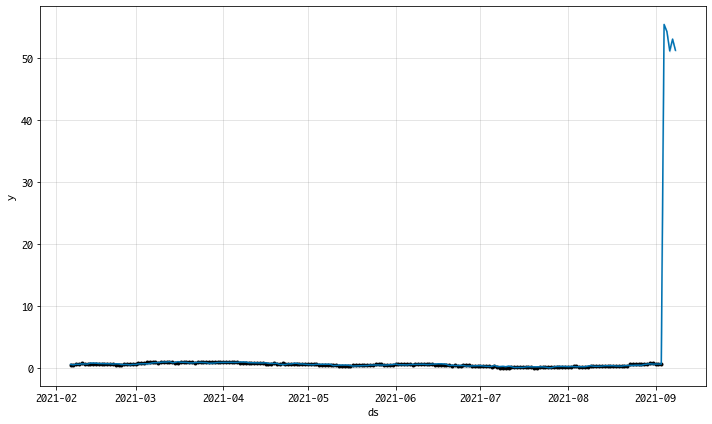

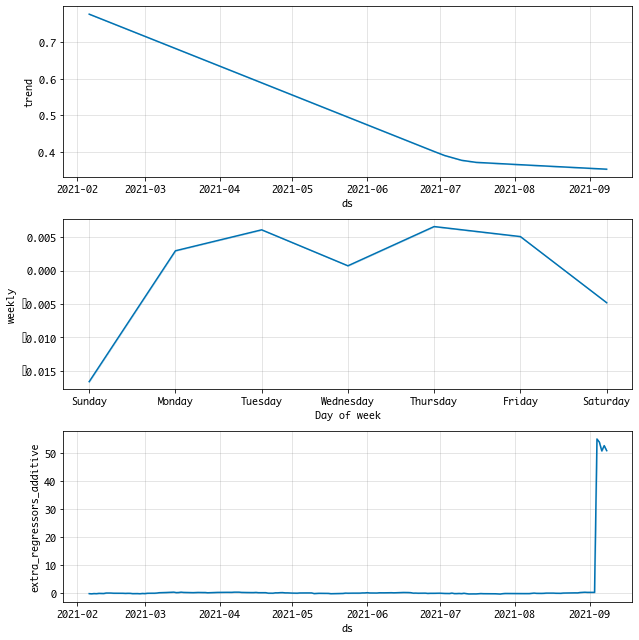

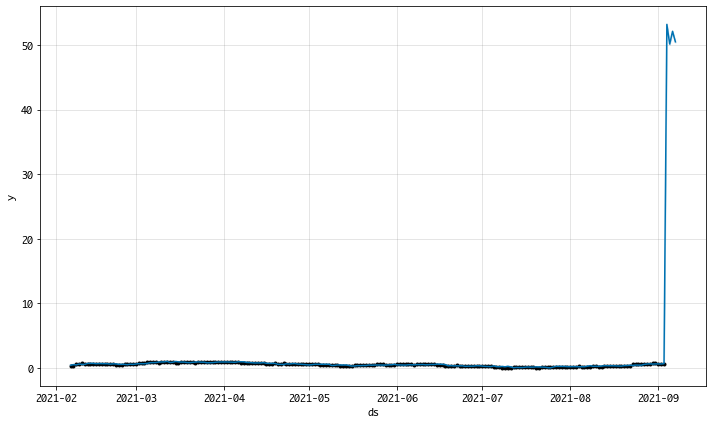

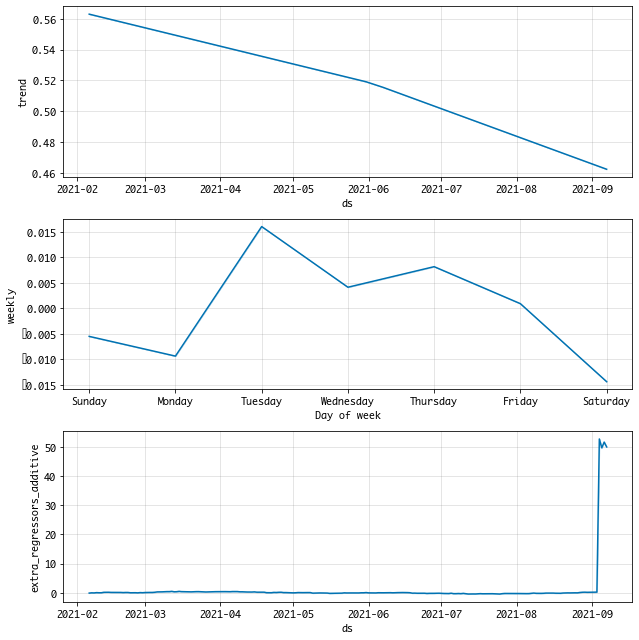

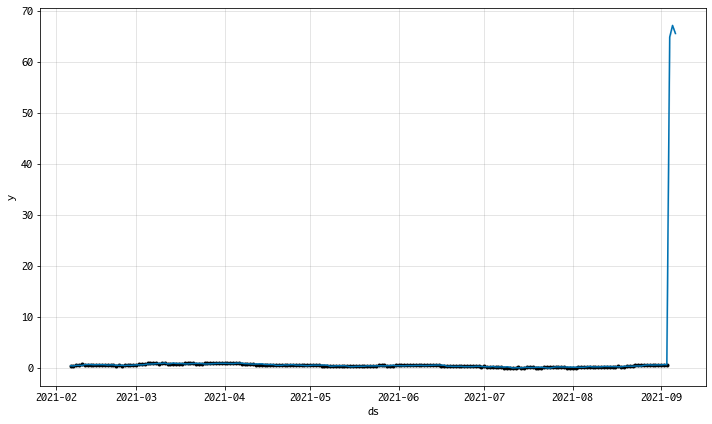

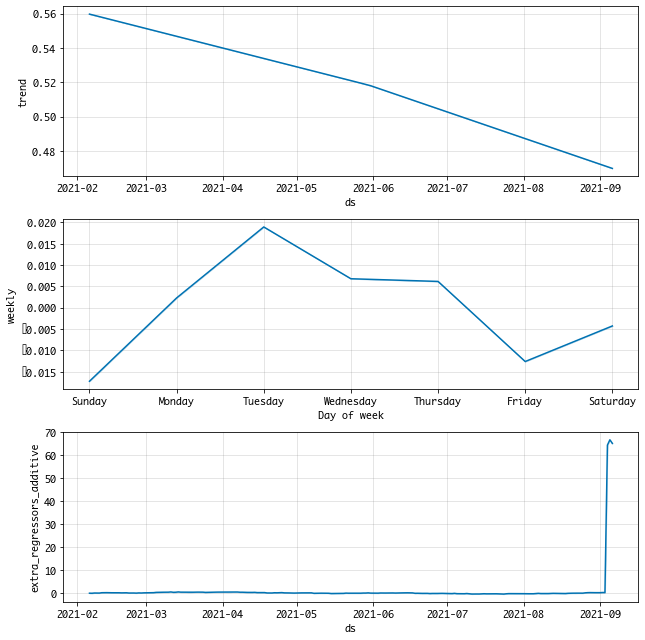

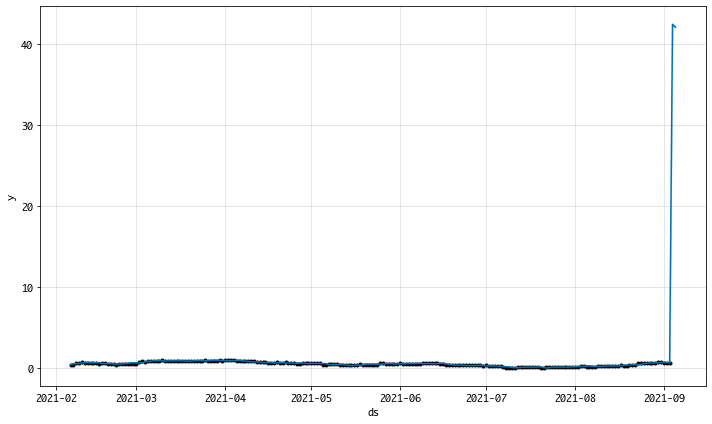

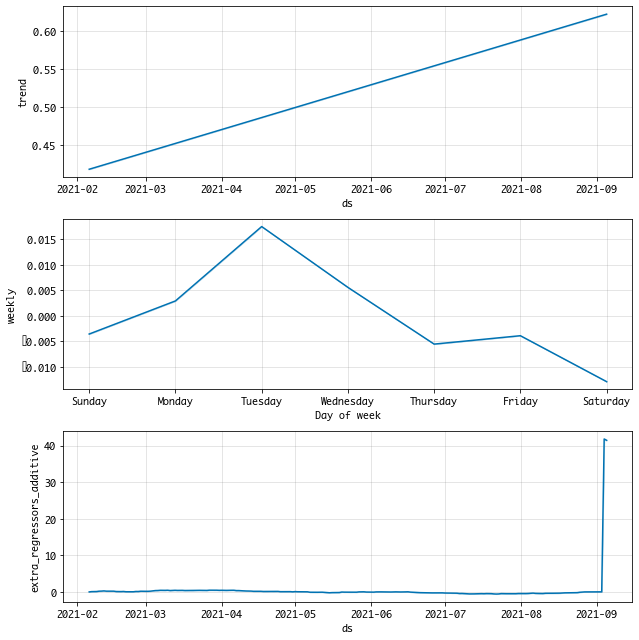

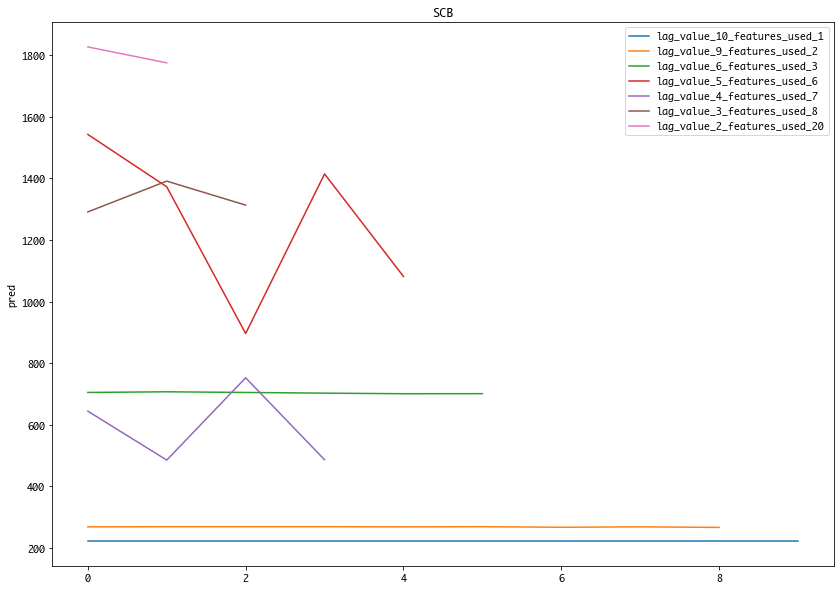

[[10,
         pred
  0  222.4087
  1  222.4087
  2  222.4087
  3  222.4087
  4  222.4087
  5  222.4087
  6  222.4087
  7  222.4087
  8  222.4087
  9  222.4087,
  1],
 [9,
           pred
  0  268.640994
  1  269.093787
  2  269.093787
  3  269.093787
  4  268.640994
  5  269.093787
  6  267.280665
  7  268.641008
  8  266.826530,
  2],
 [6,
           pred
  0  704.992139
  1  707.101228
  2  704.992139
  3  702.732543
  4  700.829496
  5  701.029397,
  3],
 [5,
            pred
  0  1542.683642
  1  1372.637423
  2   896.293528
  3  1414.461767
  4  1081.617560,
  6],
 [4,
           pred
  0  644.251462
  1  485.354430
  2  752.625720
  3  486.475184,
  7],
 [3,
            pred
  0  1291.133022
  1  1391.078945
  2  1313.177841,
  8],
 [2,
            pred
  0  1826.803677
  1  1775.080940,
  20]]

In [74]:
stock_symbol = 'SCB'
stock_all_data = sf.get_all_sources_stock_data(stock_symbol)
pred_list, prophet_model_list = get_predict_results(stock_symbol, stock_all_data)
plot_pred_results(pred_list,stock_symbol)
pred_list

File already exist....


  0%|          | 0/31 [00:00<?, ?it/s]

Fetching stock data in sector: BLISS
Fetching stock data in sector: TWZ
Fetching stock data in sector: THCOM
Fetching stock data in sector: DTAC
Fetching stock data in sector: AMR
'NoneType' object has no attribute 'rename'
Fetching stock data in sector: SAMART
Fetching stock data in sector: SDC
Fetching stock data in sector: JMART
Fetching stock data in sector: FORTH
Fetching stock data in sector: SYMC
Fetching stock data in sector: JTS
Fetching stock data in sector: PT
Fetching stock data in sector: DIF
Fetching stock data in sector: SIS
Fetching stock data in sector: JR
Fetching stock data in sector: AIT
Fetching stock data in sector: ILINK
Fetching stock data in sector: SVOA
Fetching stock data in sector: INET
Fetching stock data in sector: JAS
Fetching stock data in sector: MSC
Fetching stock data in sector: SAMTEL
Fetching stock data in sector: SYNEX
Fetching stock data in sector: JASIF
Fetching stock data in sector: ALT
Fetching stock data in sector: HUMAN
Fetching stock data in

  0%|          | 0/100 [00:00<?, ?it/s]

Fetching stock data set100: AAV
Fetching stock data set100: ACE
Fetching stock data set100: ADVANC
Fetching stock data set100: AEONTS
Fetching stock data set100: AMATA
Fetching stock data set100: AOT
Fetching stock data set100: AP
Fetching stock data set100: BAM
Fetching stock data set100: BANPU
Fetching stock data set100: BBL
Fetching stock data set100: BCH
Fetching stock data set100: BCP
Fetching stock data set100: BCPG
Fetching stock data set100: BDMS
Fetching stock data set100: BEC
Fetching stock data set100: BEM
Fetching stock data set100: BGRIM
Fetching stock data set100: BH
Fetching stock data set100: BJC
Fetching stock data set100: BTS
Fetching stock data set100: CBG
Fetching stock data set100: CENTEL
Fetching stock data set100: CHG
Fetching stock data set100: CK
Fetching stock data set100: CKP
Fetching stock data set100: COM7
Fetching stock data set100: CPALL
Fetching stock data set100: CPF
Fetching stock data set100: CPN
Fetching stock data set100: CRC
Fetching stock data set

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching stock data correlation: SCGP
Fetching stock data correlation: PSL
Fetching stock data correlation: BCH
Fetching stock data correlation: GUNKUL
Fetching stock data correlation: CHG


0it [00:00, ?it/s]

The x values include a column with constant values and so the test statistic cannot be computed.
The x values include a column with constant values and so the test statistic cannot be computed.
The x values include a column with constant values and so the test statistic cannot be computed.
The x values include a column with constant values and so the test statistic cannot be computed.
The x values include a column with constant values and so the test statistic cannot be computed.


  0%|          | 0/9 [00:00<?, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -10.5355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       425.617    0.00507478        75.137      0.2978           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       428.239   0.000969052       88.6104   1.163e-05       0.001      229  LS failed, Hessian reset 
     199       428.399   5.16287e-06       68.0324      0.3149           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235        429.78    0.00186527         104.4   1.971e-05       0.001      427  LS failed, Hessian reset 
     299       430.293   2.25557e-07       70.9926           1           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       430.347   5.46194e-05       70.5247   6.905e-07       0.001      681  LS failed, Hessian rese

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 0.1252
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1162
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1074
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0990
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0914
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0821
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0738
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0654
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0580
Epoch 10/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0505


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: INTUCH_CLOSE
data_index: 0
features_used: (200, 4)
lag value in train_test 10
[0.90170028 0.90170028 0.90170028 0.90170028 0.90170028 0.90170028
 0.90170028 0.90170028 0.90170028 0.90170028]
           pred
0  4.005469e+08
1  2.599147e+08
2  7.113725e+08
3  7.113725e+08
4  7.113725e+08
5  3.219833e+08
6  6.046614e+08
7  6.769736e+08
8  1.048889e+09
9  3.036921e+08
Initial log joint probability = -10.5355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       549.919   0.000989011        249.77   8.123e-06       0.001      137  LS failed, Hessian reset 
      99       550.248    0.00112982       121.777           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       550.488   2.42433e-06       94.7806      0.6394      0.6394      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       550.496  

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.1227
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1135
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1039
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0938
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0811
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0689
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0557
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0452
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0423
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0403


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

stock: INTUCH_CLOSE
data_index: 1
features_used: (200, 15)
lag value in train_test 9
[0.77494971 0.77494971 0.77494971 0.77494971 0.77494971 0.77494971
 0.77494971 0.77494971 0.77494971]
           pred
0  1.097891e+07
1  2.862978e+07
2  2.862978e+07
3  2.862978e+07
4  1.359847e+07
5  2.486695e+07
6  2.915174e+07
7  4.216978e+07
8  1.299773e+07
Initial log joint probability = -10.5232
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       567.293    0.00125274       149.123           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       569.691   0.000680755       104.846   7.174e-06       0.001      230  LS failed, Hessian reset 
     199       569.744   2.53265e-06       76.8266           1           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       569.745   3.23542e-08       84.0581 

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.1263
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1130
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1009
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0865
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0765
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0624
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0510
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0398
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0267
stock: INTUCH_CLOSE
data_index: 2
features_used: (200, 23)
lag value in train_test 8
[0.92664275 0.92664275 0.92664275 0.92664275 0.92664275 0.92664275
 0.92664275 0.92664275]
           pred
0  8.716274e+07
1  8.716274e+07
2  8.

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -10.4704
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       592.093     0.0047484        186.62      0.4384           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       593.373    0.00067454       85.3188           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       593.838   0.000108338       105.023      0.7032      0.7032      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        594.13   0.000194332        93.011      0.8941      0.8941      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       594.181   5.34768e-06       91.4694      0.6118      0.6118      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.1300
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1205
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1117
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1021
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0894
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0725
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0512
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0233
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0205
stock: INTUCH_CLOSE
data_index: 3
features_used: (200, 34)
lag value in train_test 7
[0.92233122 0.92233122 0.92233122 0.92233122 0.92233122 0.92233122
 0.92233122]
           pred
0  1.153364e+08
1  1.153364e+08
2  5.204318e+07


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -10.443
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       610.497    0.00513406       310.782      0.4622           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       612.627    0.00598816       204.153           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       614.114   0.000108087       85.6848      0.5616      0.5616      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       614.514    0.00235428       128.747           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       615.869     0.0108259       270.355           1           1      544   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.1303
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1182
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1073
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0948
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0818
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0660
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0470
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0363
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0239
stock: INTUCH_CLOSE
data_index: 4
features_used: (200, 37)
lag value in train_test 6
[0.8283187 0.8283187 0.8283187 0.8283187 0.8283187 0.8283187]
           pred
0  3.202507e+05
1  3.662976e+05
2  4.561432e+05
3  1.618431e+07
4 

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -10.4473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       647.712    0.00503917       610.926           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       660.827    0.00101253       337.323      0.4863           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       663.248   0.000333375       103.488           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       663.753     0.0010829       233.305           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     488       663.815    4.3241e-05       86.1934   4.679e-07       0.001      609  LS failed, Hessian reset 
     499       663.818   3.85754e-06    

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.1183
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0925
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0671
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0410
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0104
stock: INTUCH_CLOSE
data_index: 5
features_used: (200, 49)
lag value in train_test 5
[0.83600676 0.83600676 0.83600676 0.83600676 0.83600676]
           pred
0  5.165514e+07
1  1.003821e+08
2  2.677770e+08
3  2.993703e+08
4  2.55

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -10.4473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       645.414    0.00101984        326.84      0.2898      0.2898      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       664.702    0.00126056       311.333           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       666.328    0.00248141       146.732           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       667.092   4.46485e-05       135.964      0.2039      0.2039      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       667.116    3.9031e-05       105.653           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.1228
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1090
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0955
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0792
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0619
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0386
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0142
stock: INTUCH_CLOSE
data_index: 6
features_used: (200, 51)
lag value in train_test 4
[0.84174236 0.84174236 0.84174236 0.84174236]
           pred
0  5.782424e+07
1  2.808114e+08
2  1.006264e+08
3  5.130482e+07


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -10.4473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       655.688    0.00195658       1102.32           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       675.246    0.00531103       876.705      0.7411      0.7411      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        682.62   0.000303725       335.818      0.3839      0.3839      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       685.073    0.00149817       197.268      0.8797      0.8797      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       687.294    0.00118898       330.146      0.8369      0.8369      556   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.1126
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0861
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0612
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0474
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0342
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0150
stock: INTUCH_CLOSE
data_index: 7
features_used: (200, 73)
lag value in train_test 3
[0.78544637 0.78544637 0.78544637]
           pred
0 -2.857277e+07
1 -2.195755e+07
2  1.051667e+08


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -10.4473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       677.212    0.00388784       907.453           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       703.807    0.00354449        1355.9      0.2528           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       721.118    0.00160087       868.068           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       727.159   0.000181931       1088.44        0.58        0.58      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       730.574   0.000603481       223.649           1           1      538   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.1298
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1133
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0890
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0511
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0294
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0090
stock: INTUCH_CLOSE
data_index: 8
features_used: (200, 104)
lag value in train_test 2
[0.61897732 0.61897732]
           pred
0  2.124081e+08
1  4.154418e+07


/var/folders/9x/vhwmst995hn3jwhjkyh5vvlw0000gp/T/ipykernel_37789/852116697.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(14,10))


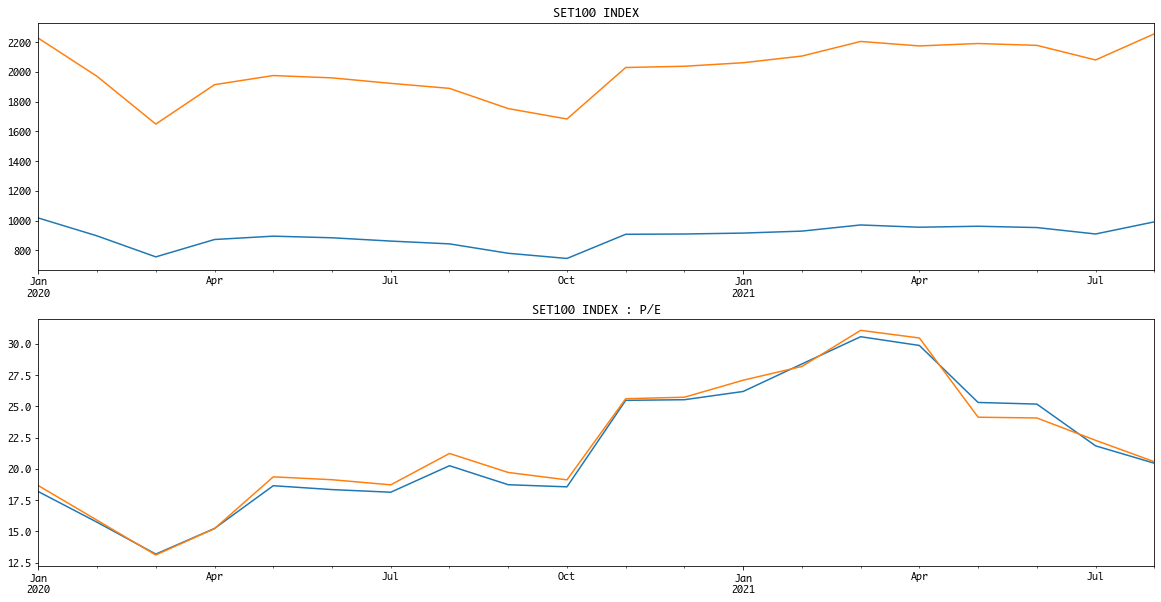

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


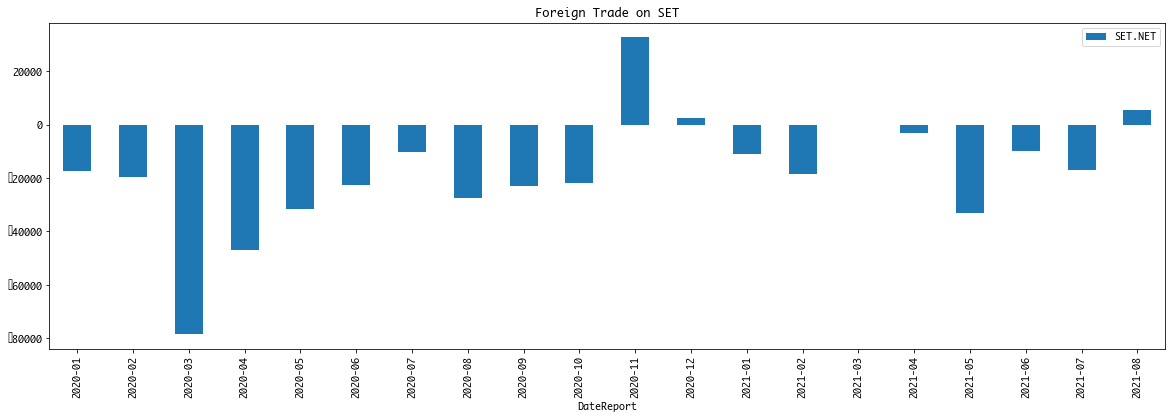

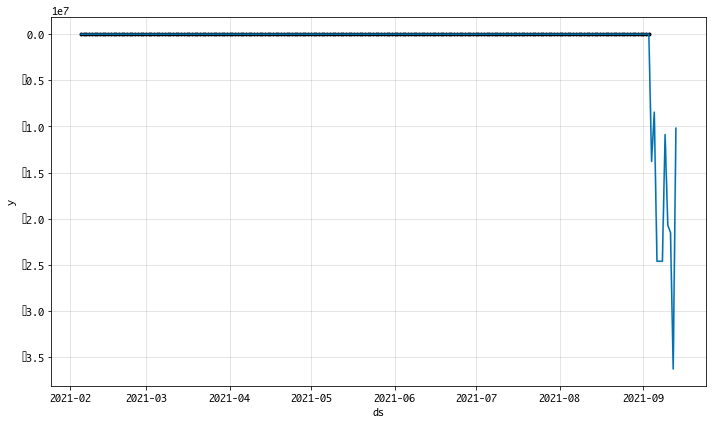

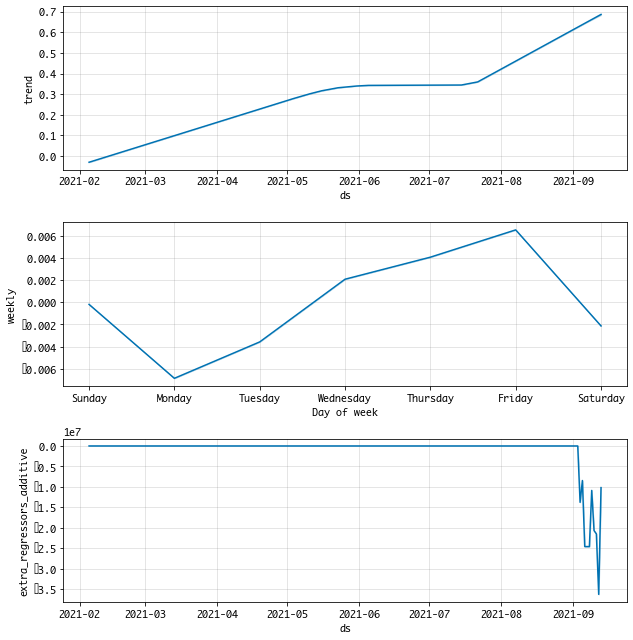

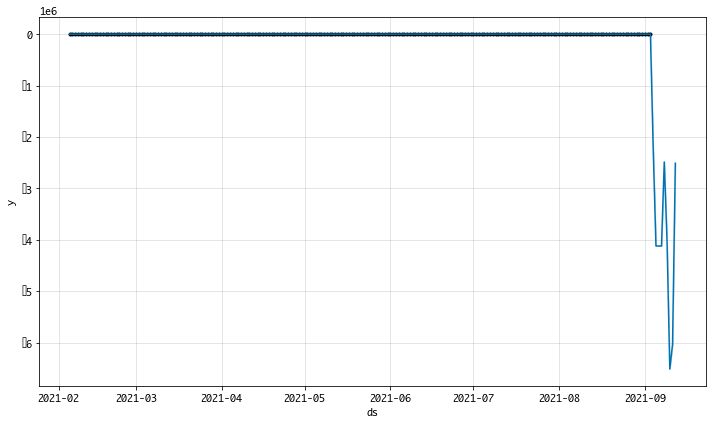

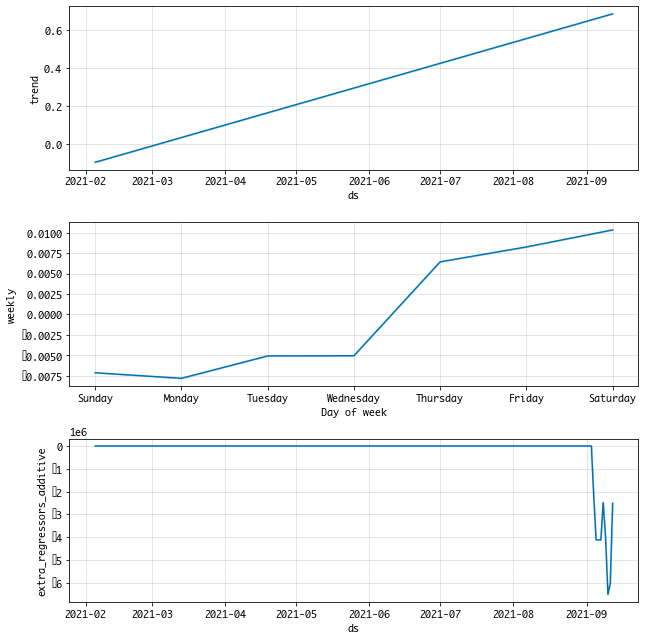

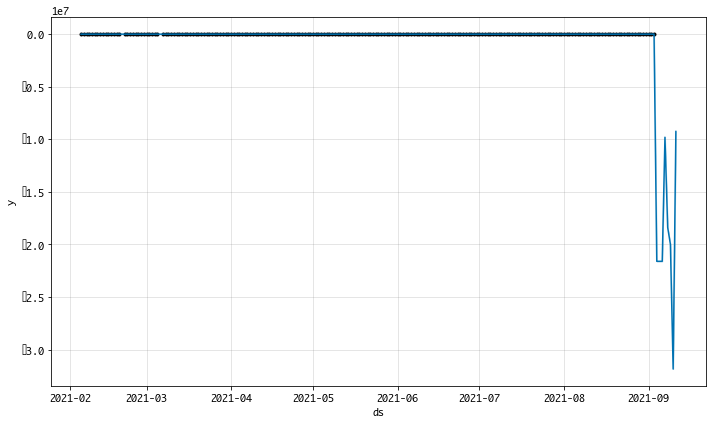

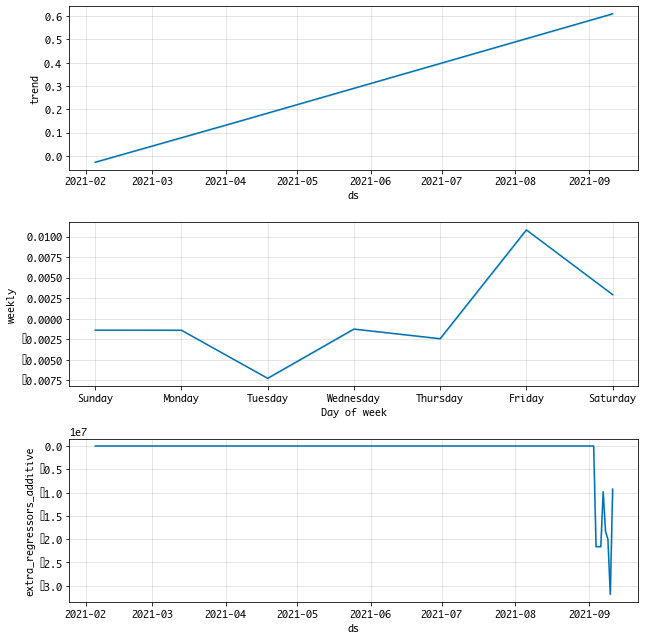

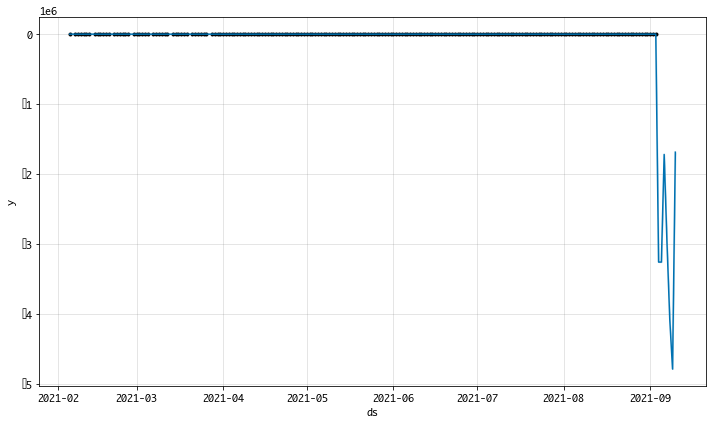

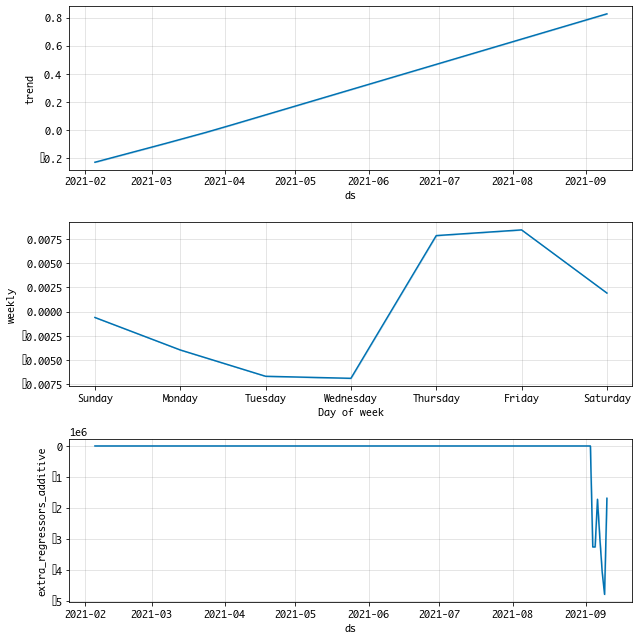

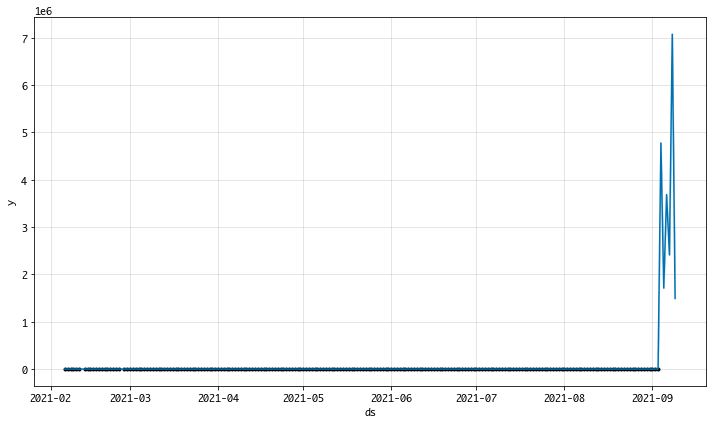

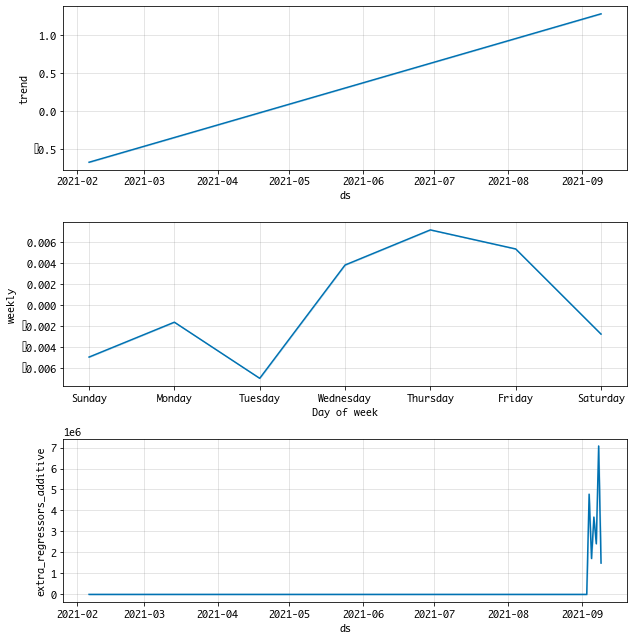

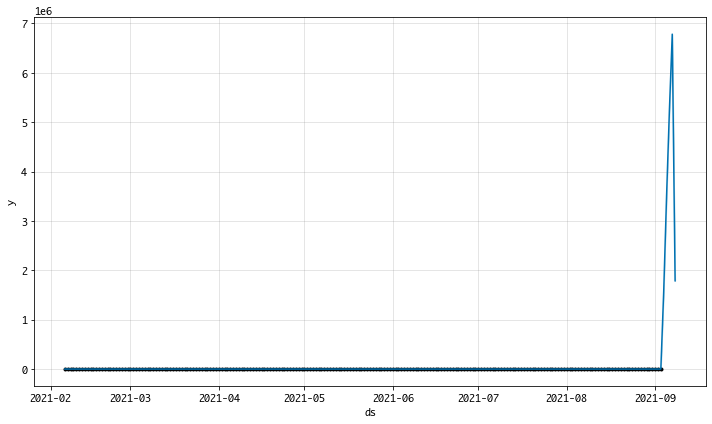

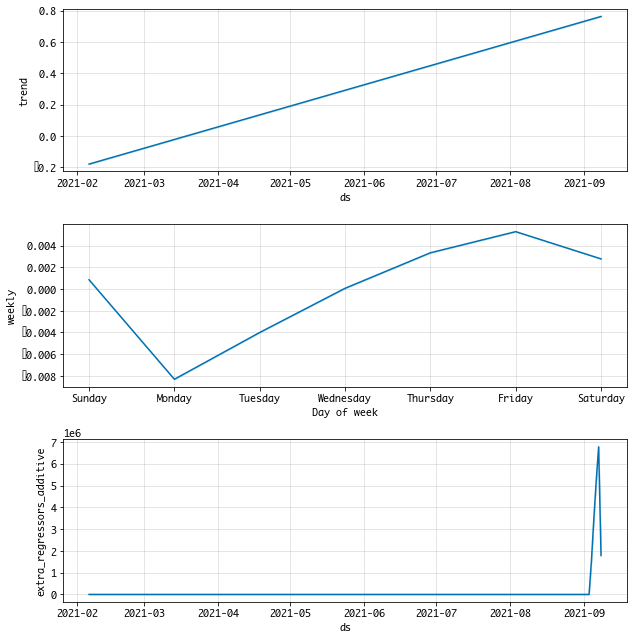

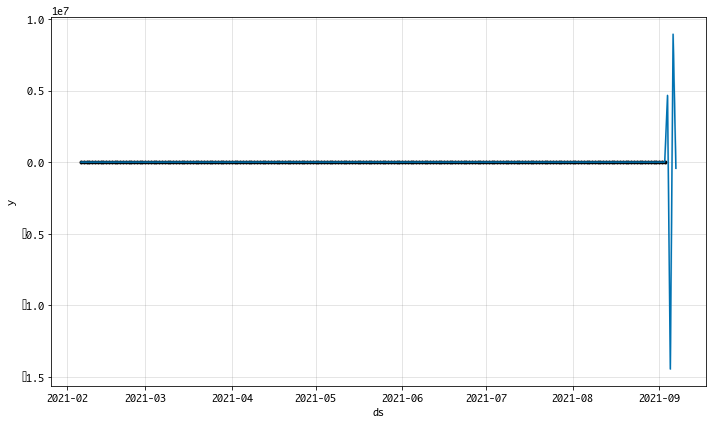

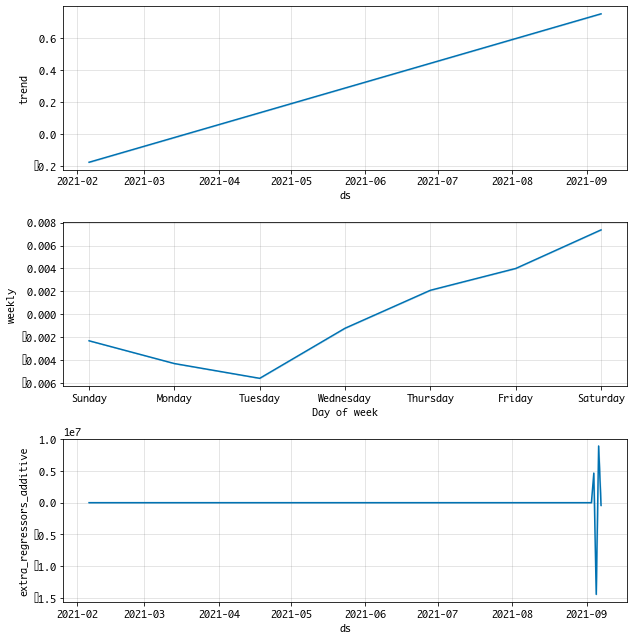

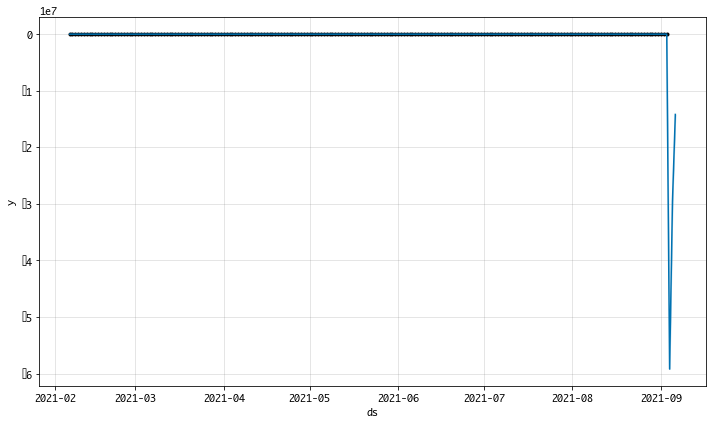

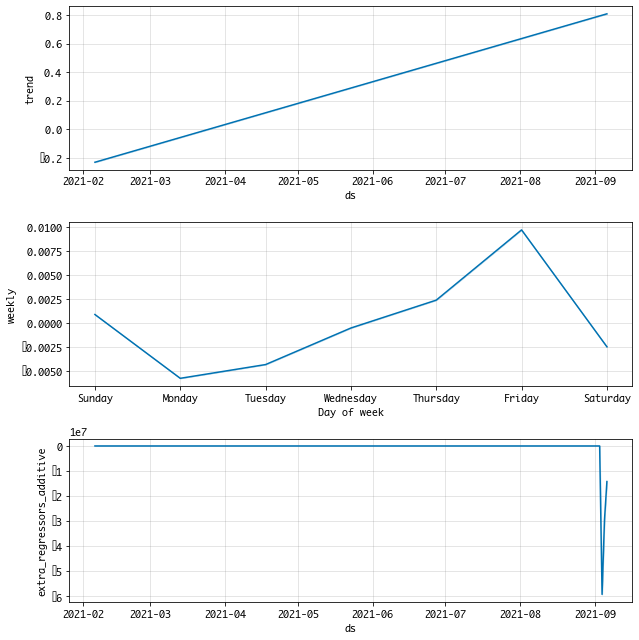

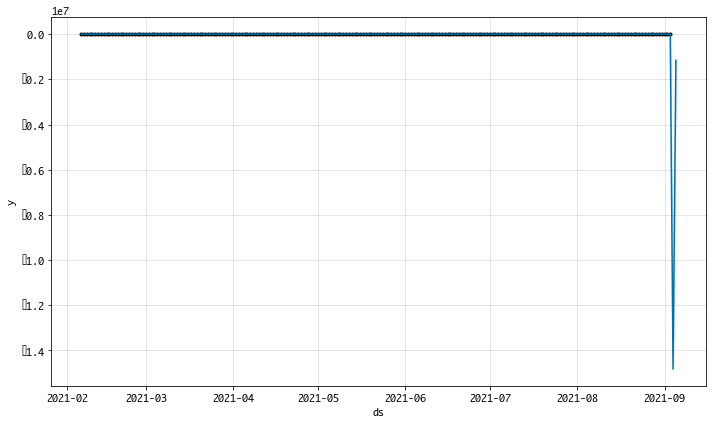

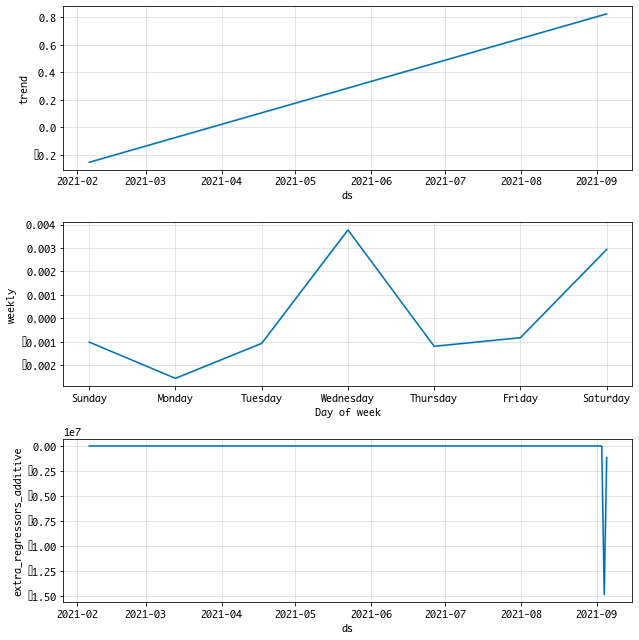

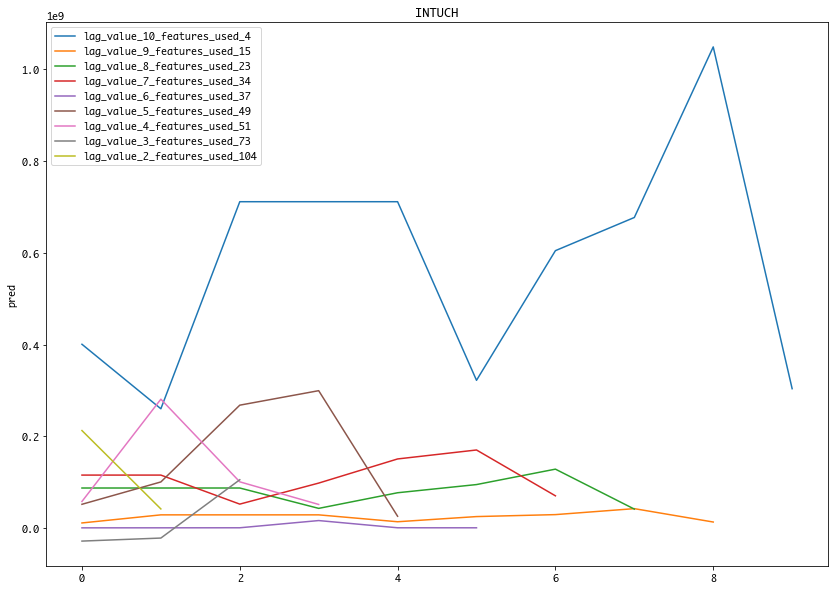

[[10,
             pred
  0  4.005469e+08
  1  2.599147e+08
  2  7.113725e+08
  3  7.113725e+08
  4  7.113725e+08
  5  3.219833e+08
  6  6.046614e+08
  7  6.769736e+08
  8  1.048889e+09
  9  3.036921e+08,
  4],
 [9,
             pred
  0  1.097891e+07
  1  2.862978e+07
  2  2.862978e+07
  3  2.862978e+07
  4  1.359847e+07
  5  2.486695e+07
  6  2.915174e+07
  7  4.216978e+07
  8  1.299773e+07,
  15],
 [8,
             pred
  0  8.716274e+07
  1  8.716274e+07
  2  8.716274e+07
  3  4.274830e+07
  4  7.682732e+07
  5  9.466676e+07
  6  1.282932e+08
  7  4.120465e+07,
  23],
 [7,
             pred
  0  1.153364e+08
  1  1.153364e+08
  2  5.204318e+07
  3  9.790150e+07
  4  1.505230e+08
  5  1.700696e+08
  6  7.012921e+07,
  34],
 [6,
             pred
  0  3.202507e+05
  1  3.662976e+05
  2  4.561432e+05
  3  1.618431e+07
  4  4.570861e+05
  5  4.048914e+05,
  37],
 [5,
             pred
  0  5.165514e+07
  1  1.003821e+08
  2  2.677770e+08
  3  2.993703e+08
  4  2.559937e+07,
  49],
 [4,

In [75]:
stock_symbol = 'INTUCH'
stock_all_data = sf.get_all_sources_stock_data(stock_symbol)
pred_list, prophet_model_list = get_predict_results(stock_symbol, stock_all_data)
plot_pred_results(pred_list,stock_symbol)
pred_list

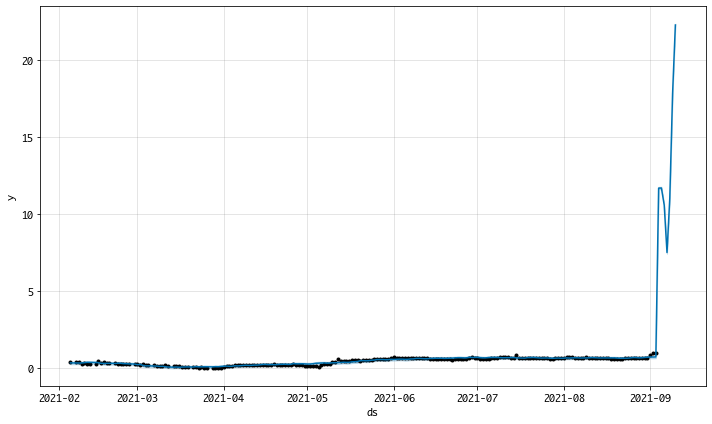

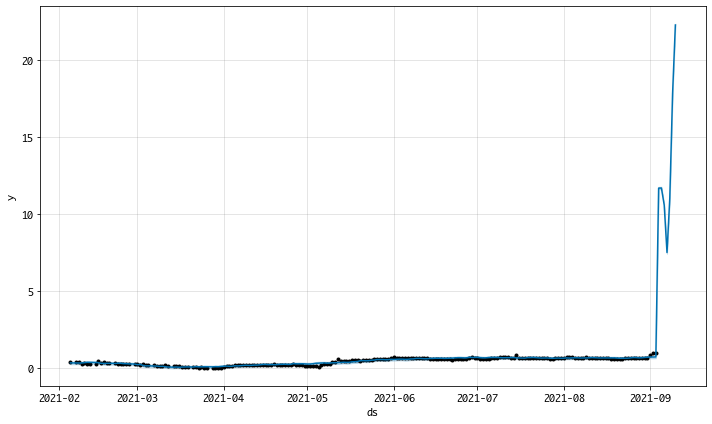

In [77]:
prophet_model_list[3][0].plot(prophet_model_list[3][1])